In [1]:
# !pip install missingno
# !pip install pyampute
# !pip install upsetplot
# !pip install lightgbm

# Handling Missing Values: A Comprehensive Guide

## Why this notebook?

Missing data can  
* **Bias your insights** – misleading parameter estimates and conclusions  
* **Reduce statistical power** – fewer usable observations means wider confidence intervals  
* **Break ML pipelines** – many algorithms fail when they see `NaN`s  

This hands-on notebook shows you how to **detect, diagnose, visualise, and impute** missing values **responsibly** so you can keep your analysis honest and your models robust.

---

## Taxonomy of Missingness

| Abbrev. | Full Name | Intuition (casual definition) | Typical Analytical Consequence |
|---------|-----------|------------------------------|--------------------------------|
| **MCAR** | Missing Completely at Random | The fact a value is missing is unrelated to anything – seen or unseen | List-wise deletion remains unbiased (but costs sample size) |
| **MAR** | Missing at Random | Missingness depends only on other observed variables (e.g., low-income fields absent mostly among younger respondents) | Statistical imputation is usually valid and efficient |
| **MNAR**<br>(a.k.a. **NMAR**) | Missing Not at Random | Missingness depends on the value itself (e.g., people with *very* high incomes omit the field) | Must model the missing-data mechanism or use specialised techniques (e.g., selection models) |

> **Rule of thumb:** if you can build a decent classifier that predicts `is_NA` from the other columns, consider the pattern **MAR** rather than MCAR.

---


## Why do values go missing?

Common root causes to watch for:

* **Data-entry errors** – typos, OCR failures, manual form mistakes  
* **Sensor or logging failures** – IoT outages, packet loss, corrupt log files  
* **Survey design quirks** – skip logic, privacy opt-outs, conditional questions  
* **Time-based gaps** – product not launched yet, customer not yet active, late-arriving data  
* **Domain/business rules** – suppressed divisions by zero, calculated fields unavailable at ingest time  

> **Checklist tip:** Start a running log for your project. Each time you discover a new reason for missingness, record it along with affected variables, dates, and remediation steps. Clear provenance saves headaches later.

---

In the sections that follow, we will:

1. **Audit** missingness with summary metrics and visual diagnostics.  
2. **Diagnose** the mechanism (MCAR / MAR / MNAR) with statistical tests and predictive models.  
3. **Compare** common remedies – from simple mean/median fills to MICE, K-NN, and model-based imputations.  
4. **Evaluate** the impact of each strategy on downstream modelling performance.

Let’s dive in!


In [2]:
# Core
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # pip install missingno
from upsetplot import UpSet, from_indicators

# Imputation tools
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer,
                             KNNImputer,
                             IterativeImputer)
from sklearn.experimental import enable_iterative_imputer  # noqa: F401

# Get data
from sklearn.datasets import fetch_openml

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from scipy import stats

from scipy.stats import chi2
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor     
from sklearn.base import clone


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Example Dataset
# OpenML “house_prices” = Ames Housing (79 predictors + SalePrice target)
ames = fetch_openml(name="house_prices", version=1, as_frame=True)  # 2 930 rows × 81 cols
df = ames.frame               # full DataFrame, predictors + target
df.drop(columns = 'Id', inplace = True)
df_original = df.copy()
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
# Split Features: Numerical vs Categorical
num_cols = df.select_dtypes(include="number").columns
cat_cols = df.select_dtypes(exclude="number").columns

print(f'num_cols: {num_cols}')
print()
print(f'cat_cols: {cat_cols}')

num_cols: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

cat_cols: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    

## Exploratory Missing-Data Visualisation

Before fixing *any* `NaN`, it is essential to **see** how and where the gaps occur.  
Good visuals turn thousands of table cells into an intuitive snapshot that instantly answers:

* **How much data is missing?**&nbsp;— overall burden and per-column “risk”.
* **Where is it missing?**&nbsp;— specific features, time periods, or record groups.
* **Are gaps isolated or systematic?**&nbsp;— hints at the *mechanism*:
  * **MCAR** (Missing Completely at Random) → scattered, no clear pattern  
  * **MAR** (Missing at Random)      → linked to other observed features  
  * **MNAR** (Not at Random)      → depends on the unobserved value itself  

Understanding these patterns shapes every downstream decision:

| Visual Insight | Typical Conclusion | Modelling / Cleaning Action |
|----------------|-------------------|-----------------------------|
| Sparse, pattern-less noise | Likely MCAR | Simple deletion or mean/median impute |
| Blocks tied to a category (e.g. `Cabin` empty for `pclass==3`) | MAR | Model-based or conditional imputation |
| Entire variable missing for a sub-population | Data-collection issue | Re-survey, drop feature, or build cohort-specific models |
| Missingness predicts the target (e.g. lifeboat # only for survivors) | MNAR | Keep `is_na` flag as a valuable feature |

### Common Visualisation Techniques & How They Help

| Technique | Library / Tool | Best For | What You Learn |
|-----------|---------------|----------|----------------|
| **Missing-value bar chart** (`df.isna().sum()`) | pandas + Matplotlib / Seaborn | Quick audit | Rank variables by missingness; spot those exceeding a threshold |
| **Heat-/matrix plot** (`missingno.matrix`) | `missingno` | Cell-level overview | Streaks & clustering over rows (e.g. periods of sensor failure) |
| **Missingness correlation heatmap** (`missingno.heatmap`) | `missingno` | Relationships between gaps | Detect MAR links such as pairs of columns missing together |
| **Dendrogram / cluster map** (`missingno.dendrogram`) | `missingno` | Grouping features by gap similarity | Suggests joint imputation blocks or variables to drop together |
| **UpSet / set plot** (`upsetplot`, `plotly`) | `upsetplot`, `plotly` | Complex intersection patterns | Which exact combinations of columns are simultaneously missing |
| **Scatter or pair plot with `NaN` hue** | Seaborn / Plotly | Continuous features | Whether missingness in one variable aligns with value ranges of another |
| **Temporal heatmap** (index as time) | Matplotlib / Seaborn | Time-series data | Periods of outages; helps decide forward-/back-fill strategies |
| **Geographical map** (`geopandas`, `folium`) | Geo datasets | Spatial gaps | Regions with systematic non-responses or sensor dropouts |

> **Tip:** combine at least *one* whole-dataset plot (bar/heatmap) with *one* relationship-oriented plot (correlation, scatter) to cover both the *amount* and the *structure* of missingness.

### From Visuals to Strategy

1. **Quantify** – High-missing columns → consider dropping or specialised models.  
2. **Diagnose** – Patterns suggest MCAR/MAR/MNAR → choose appropriate imputation.  
3. **Engineer** – Retain informative `is_na` flags when gaps carry signal.  
4. **Validate** – Re-plot after imputation to ensure artefacts are gone.

Investing a few minutes in rich visual diagnostics prevents blindly applying one-size-fits-all imputations and preserves the integrity (and credibility) of your analysis.


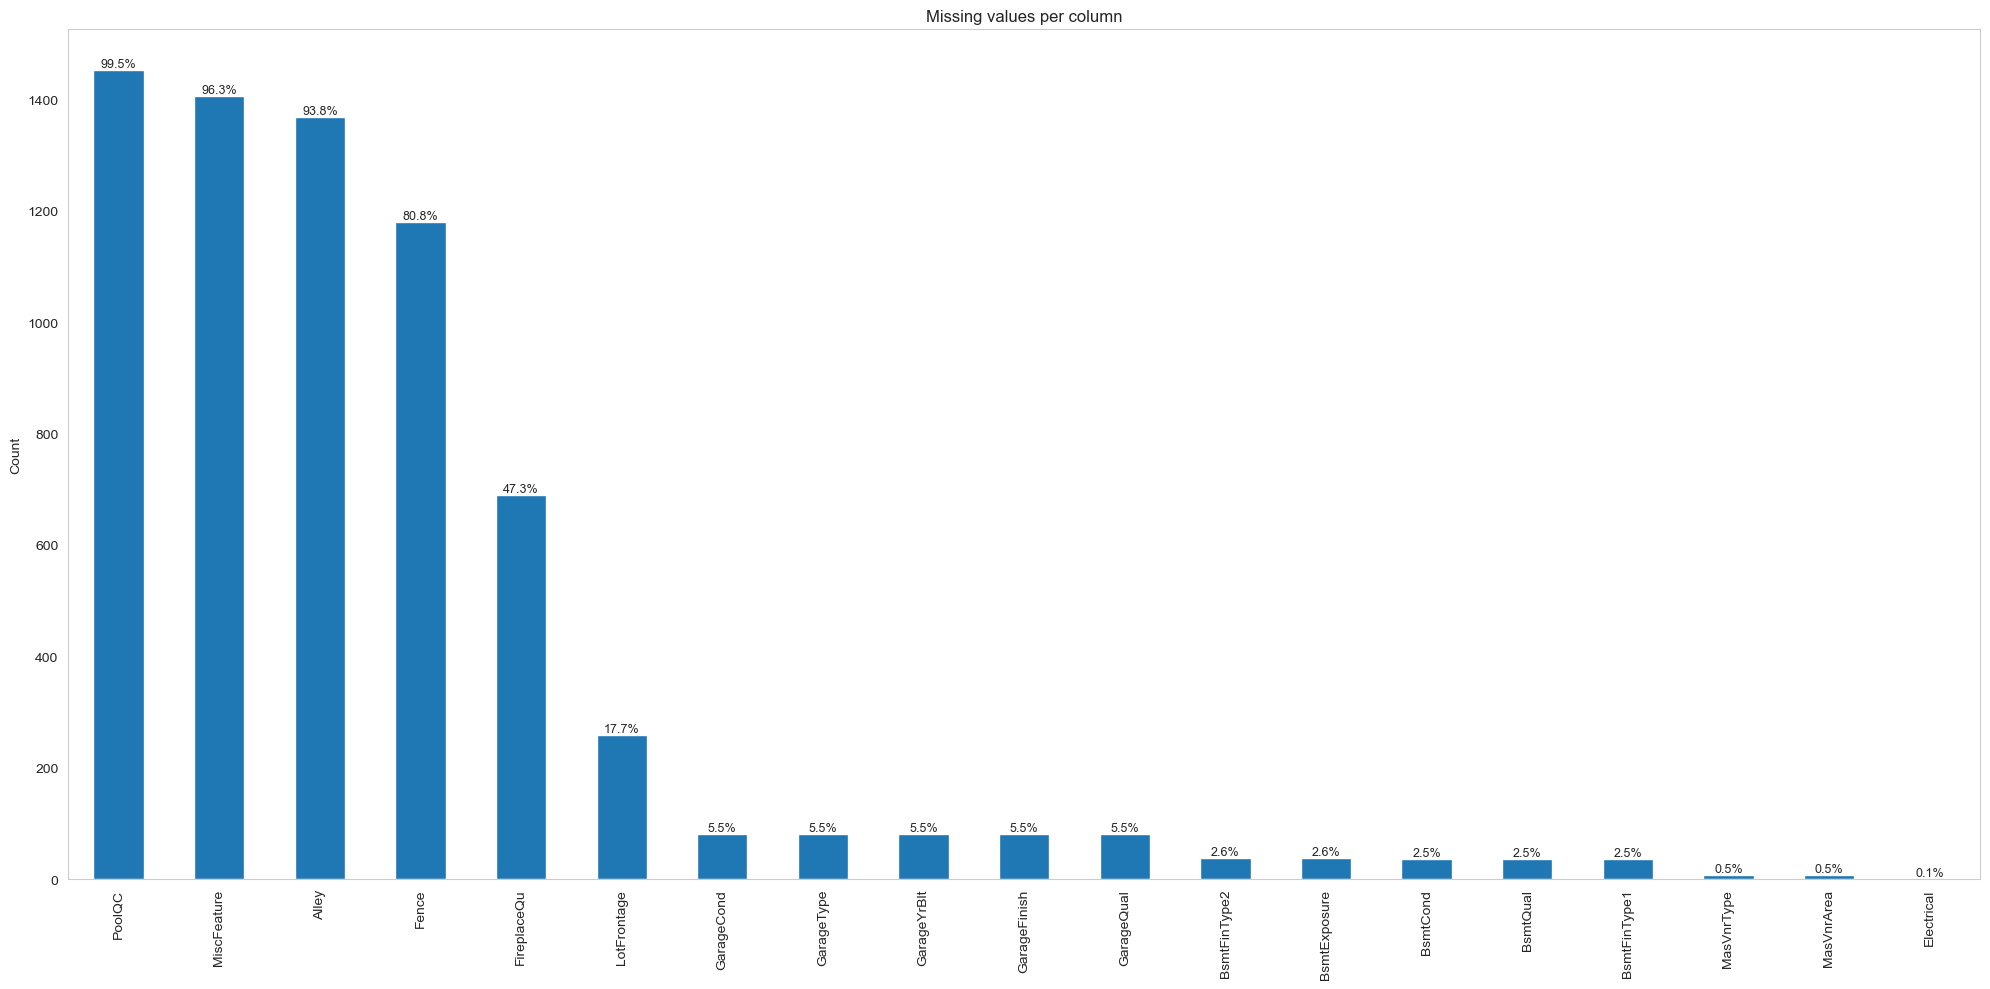

In [6]:
# ── 1. Count only columns that actually have NAs ────────────────────────────────
na_counts = df.isna().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)   # keep cols with ≥1 NA
na_props  = na_counts / len(df)                                     # proportion per col

# ── 2. Plot ────────────────────────────────────────────────────────────────────
ax = na_counts.plot.bar(figsize=(20, 10), title="Missing values per column")
ax.set_ylabel("Count")
ax.grid(False)

# percentage labels
for patch, prop in zip(ax.patches, na_props):
    ax.annotate(f"{prop:.1%}",
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

### Interpreting the “Missing Values per Column” Bar Chart

The bar chart ranks every feature by **absolute number of NaNs** (left → right) and annotates the **percentage of the data set that is missing** above each bar.

* **Near-complete gaps (≈ 80 – 100 %)**  
  *`PoolQC`, `MiscFeature`, `Alley`, `Fence`*  
  Only a handful of houses report these attributes; the *absence* usually means “feature not present” (e.g., no pool ⇒ no pool quality to record).

* **Moderate gap (≈ 47 %)**  
  *`FireplaceQu`*  
  Roughly half the houses lack a fireplace; again, missingness likely encodes *structural absence* rather than data-entry error.

* **Low–to–mid gaps (≈ 18 % and < 6 %)**  
  *`LotFrontage`* (17.7 %) may reflect survey difficulties or subdivision types, while the garage-related variables (≈ 5 %) suggest a few properties without garages or with unrecorded details.

* **Tiny gaps (< 1 %)**  
  *`MasVnrType`, `MasVnrArea`, `Electrical`*  
  These are classic “data glitches” that can often be fixed with simple imputation or row deletion.

---

#### How does this visual help?

1. **Immediate triage** – You instantly see which columns dominate the missing-data problem and deserve bespoke treatment.
2. **Pattern clues** – The sharp separation between *almost-empty* and *mostly-filled* features hints that different mechanisms are at play.
3. **Communication** – Stakeholders grasp the scale of the issue without scrolling through numeric tables.

---

#### Can we already infer the missing-data mechanism?

| Feature group | Likely mechanism | Reasoning |
|---------------|-----------------|-----------|
| PoolQC, MiscFeature, Alley, Fence | **MNAR / structural** | NaN means the feature literally does not exist (no pool ⇒ no quality). |
| FireplaceQu | **MNAR** | Similar logic: no fireplace ⇒ no fireplace quality. |
| LotFrontage | **MAR** | Missingness may depend on neighbourhood layout or lot configuration recorded elsewhere in the data. |
| Garage* vars | **MAR / MNAR mix** | Houses without garages vs. data-entry omissions. |
| MasVnr*, Electrical | **MCAR / data glitch** | Very low rates, no obvious pattern yet. |

> 🔍 **Caveat:** Visual inspection is suggestive, not definitive. Statistical tests (e.g., Little’s MCAR test) and domain knowledge are needed to confirm.

---

#### Can we define a treatment strategy now?

We can **sketch** a plan:

| Feature group | Candidate treatment |
|---------------|--------------------|
| ≳ 80 % missing | Convert to “has_feature” flag and keep as categorical (*‘None’* vs. quality level), or drop if irrelevant to the modelling goal. |
| 40 – 50 % missing | Encode “has_fireplace” flag; possibly leave quality NaN where no fireplace exists. |
| 15 – 20 % missing | Impute `LotFrontage` with neighbourhood-median or K-NN imputation conditioned on lot characteristics. |
| ≤ 5 % missing | Mode/median imputation or rowwise deletion; add `is_na` indicator if NaN may carry signal. |

But we still need to **validate** whether these choices preserve predictive power and avoid bias.

---

#### What should we do next?

1. **Relationship plots** – Use `missingno.heatmap()` or an UpSet plot to see which NaNs co-occur.  
2. **Mechanism testing** – Run Little’s MCAR test or compare distributions of observed vs. missing groups.  
3. **Flag engineering** – Create `is_na` indicators for features where missingness itself is informative (e.g., fireplace presence).  
4. **Prototype imputations** – Apply a few candidate methods (median, K-NN, multivariate imputation) and *re-plot* to ensure no obvious artefacts remain.  
5. **Model impact check** – Train a quick baseline model with and without engineered flags/imputation to measure lift and guard against leakage.

By iterating through these steps, you’ll transform a static bar chart into a fully-defensible missing-data remediation plan.


<Figure size 1000x800 with 0 Axes>

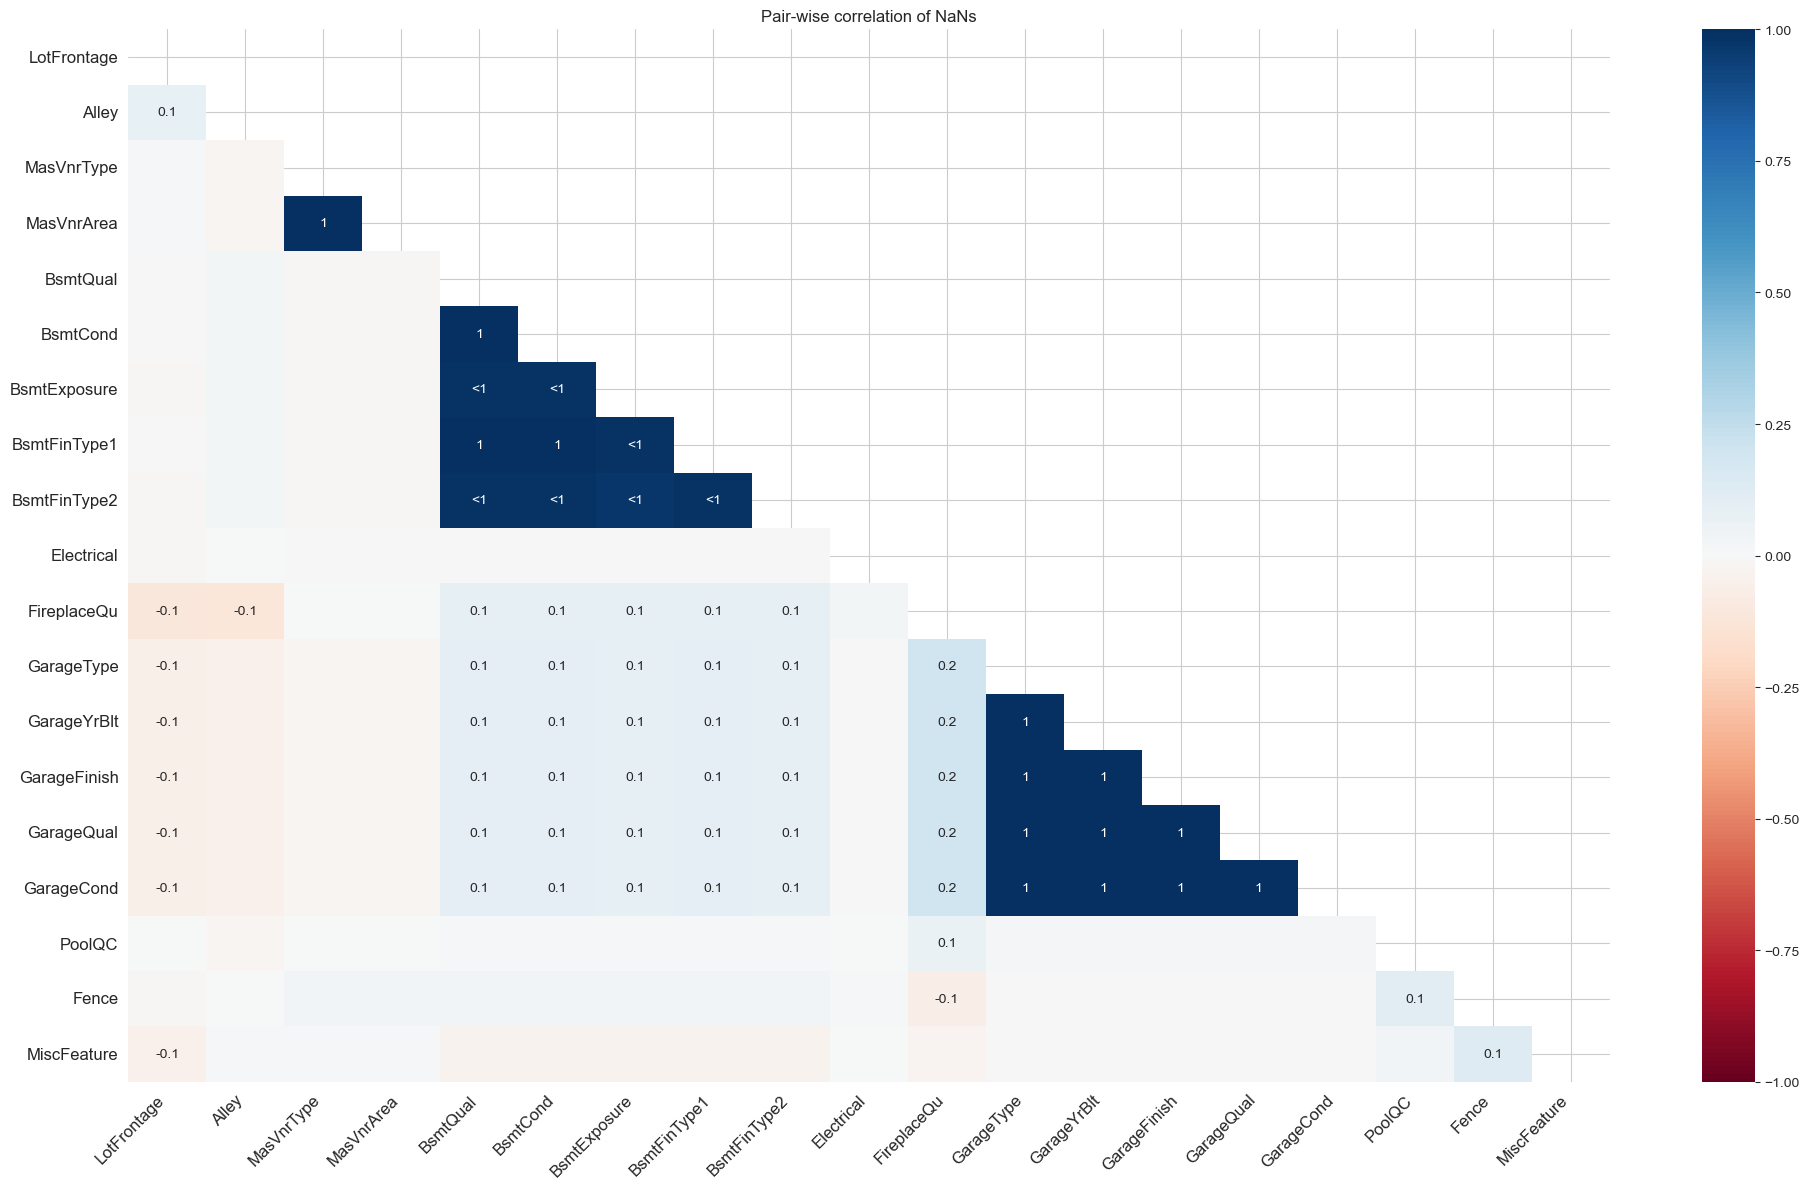

In [7]:
# --------------------------------------------------------------------------
# Missing-value *correlation* heat-map  (missingno.heatmap)
# --------------------------------------------------------------------------
plt.figure(figsize=(10, 8))
msno.heatmap(df, fontsize=12)   # darker = strong co-occurrence
plt.title("Pair-wise correlation of NaNs")
plt.tight_layout()
plt.show()

# Interpretation guideline:
# • Dark squares (correlation ↑) → the two variables tend to be NaN together
# • Light/blank squares          → independence
# • A full dark row/column       → consider block-wise imputation or dropping

### Reading the *Pair-wise Correlation of NaNs* Heat-Map

The heat-map shows **Spearman correlations between each pair of “is NaN” indicators**  
(`1 = two columns are *always* missing together; −1 = one is missing *exactly when* the other is present).  
Only the lower triangle is populated to avoid duplication.

| Main pattern | Interpretation | Likely missingness mechanism |
|--------------|----------------|------------------------------|
| **Deep-blue 1.0 block:**<br>`BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2` | Whenever one basement feature is NaN, *all* of them are NaN. | **Structural MNAR** – houses without a basement simply have no basement attributes to record. |
| **Second 1.0 block:**<br>`GarageType`, `GarageYrBlt`, `GarageFinish`, `GarageQual`, `GarageCond` | Same logic for garages: missingness travels as a cohesive unit. | **Structural MNAR** – “no garage” implies no garage details. |
| **Weak positive ties (≈ 0.1):**<br>`Alley` with a few others; `Fence` with `PoolQC` | Sparse, diffuse links; probably noise or shared property class. | **Possibly MAR** – may depend on neighbourhood characteristics. |
| **Weak negative ties (≈ -0.1):**<br>`FireplaceQu` vs. garage/basement block | Houses lacking a fireplace tend *not* to lack a garage/basement. | Suggests *sub-populations* of house types. |

---

#### How does this help?

* **Feature grouping → block-wise strategy**  
  Basement and garage attributes form *imputation blocks*. Handle them together (or flag entire block as “none”).
* **Mechanism insight**  
  Perfect correlation + clear domain meaning → strong evidence of **MNAR due to structural absence**, not data error.
* **Noise filtering**  
  Variables with near-zero correlations (`LotFrontage`, `Electrical`) behave independently → treat them separately.

---

#### Can we already decide on treatments?

| Feature set | Practical action |
|-------------|------------------|
| **Basement 5-pack** | Create binary `has_basement` flag.<br>Keep quality vars; treat *NaN = “No basement”* (categorical “None”). |
| **Garage 5-pack** | Analogous `has_garage` flag + “None” category for each qualitative field. |
| **Alley, Fence, PoolQC, MiscFeature** | Very sparse → keep as “None”/dummy **or** drop if not predictive. |
| **LotFrontage** | Missing independently → neighbourhood-conditional median/K-NN imputation. |
| **Electrical (0.1 % NaN)** | Simple mode imputation or row deletion. |

> **Caveat:** The heat-map is descriptive; always validate with domain experts or statistical tests (e.g., Little’s MCAR) before locking decisions.

---

#### Recommended next steps

1. **Confirm with UpSet plot** to ensure no hidden higher-order patterns remain.  
2. **Engineer `is_na` flags** for blocks where missingness itself predicts price (e.g. `has_basement`).  
3. **Prototype imputations** (block-conditional for basement/garage, median for numeric stragglers).  
4. **Re-plot** the heat-map after imputation—ideal outcome is a blank or near-blank matrix.  
5. **Model checkpoint**—compare a baseline model *with* vs. *without* the engineered flags to quantify the signal carried by missingness.


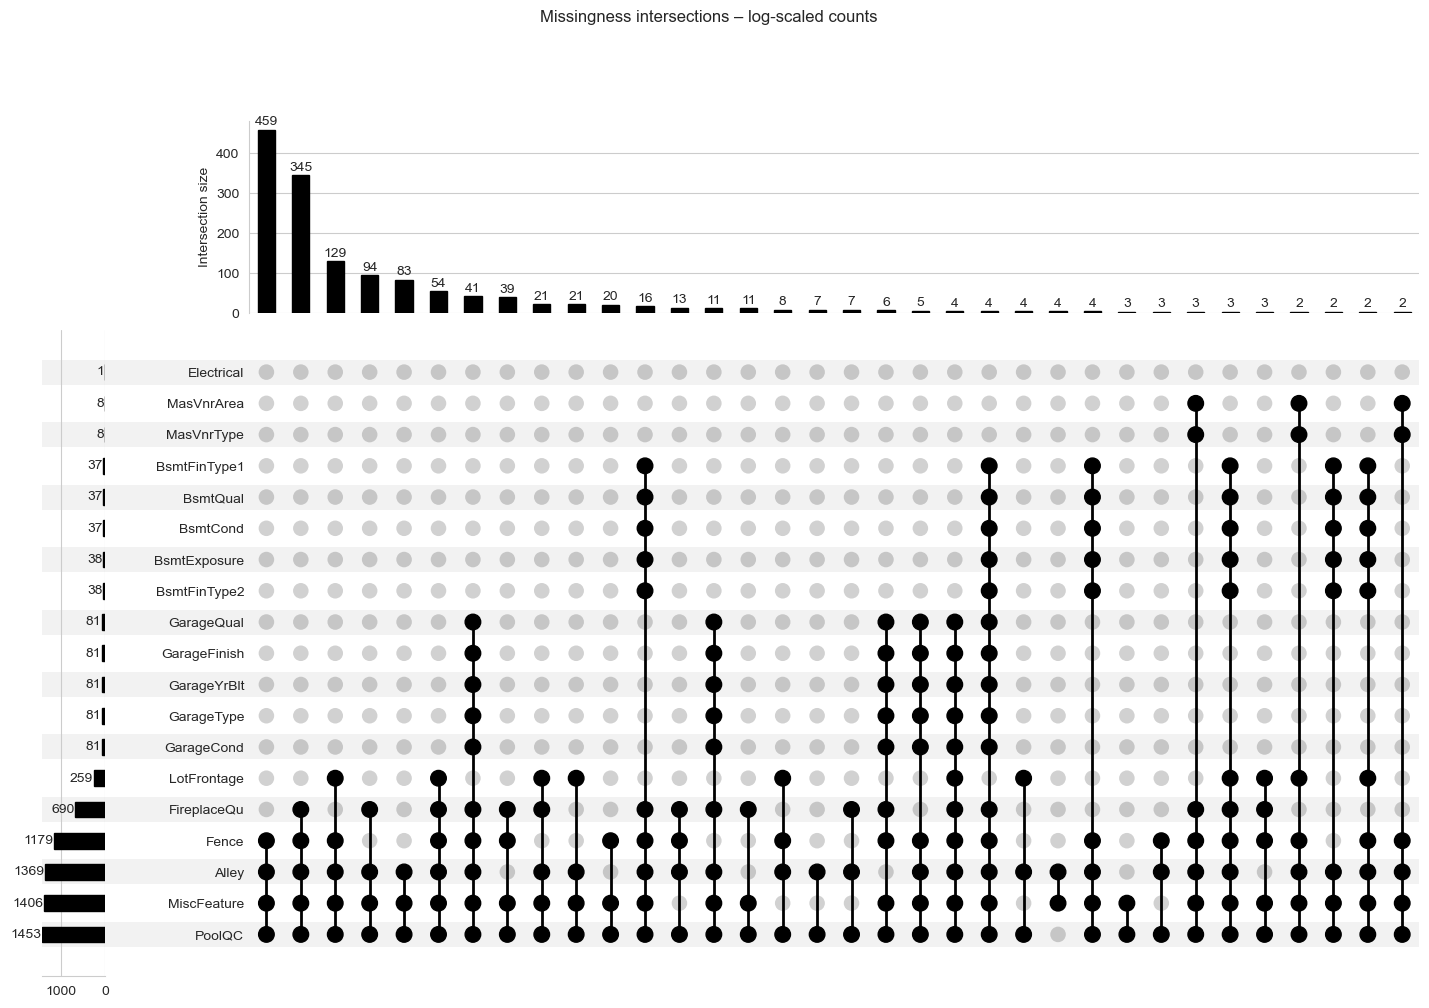

In [8]:
missing_cols = df.columns[df.isna().any()]
upset_data   = from_indicators(df[missing_cols].isna())

u = UpSet(
    upset_data,
    subset_size="count",
    show_counts=True,
    sort_by="cardinality",
    min_degree=2,          # hide single-column gaps
    min_subset_size=2      # hide 1–4-row quirks
)
u.plot()     

plt.suptitle("Missingness intersections – log-scaled counts")
plt.show()

### Decoding the UpSet Plot – “Exact Combinations of Missing Columns”

The UpSet diagram breaks down **how entire *sets* of variables are missing together in the same rows**.

| Visual element | What it shows | How to read it |
|----------------|---------------|----------------|
| **Top bar chart (black bars)** | Size of each intersection = **how many rows have *exactly* that pattern of NaNs** | All bars are height = 1 here → every pattern is rare (only 1 row each). |
| **Left-side mini-bars** (numbers like 57, 46, 32) | **Univariate counts** = total rows where that single column is NaN | `PoolQC` (57) → most frequently missing column overall. |
| **Dot matrix** (columns of dots connected by vertical lines) | **Which columns participate in each intersection** | A vertical line with filled dots on `Garage*` marks a row where *all* five garage attributes are simultaneously missing. |

#### Key observations

* **Basement block**  
  Rows with the five `Bsmt*` variables missing appear together (counts ≈ 12).  
  &rarr; Confirms the *structural* absence detected in the heat-map.
* **Garage block**  
  Similar five-column pattern (`Garage*`, counts ≈ 16).  
  &rarr; “No garage” rows require a joint treatment.
* **Sparse one-offs**  
  Many single-row bars (height = 1) with eclectic combinations.  
  &rarr; Indicative of **idiosyncratic glitches** rather than systematic mechanisms.
* **PoolQC, Fence, MiscFeature**  
  Often missing *alone* → their dots rarely align with other columns.  
  &rarr; Missingness mainly **isolated** to the feature itself (structural MNAR: feature not present).

#### How does this complement the heat-map?

* **Heat-map** told us *pair-wise* ties; **UpSet** verifies *higher-order* intersections.  
* It confirms that basement & garage variables disappear as coherent *blocks*, while `LotFrontage`, `Electrical`, etc. vanish mostly *solo*.

#### Can we infer missing-data mechanisms?

| Pattern | Likely mechanism | Evidence |
|---------|-----------------|----------|
| Basement & Garage 5-packs | **Structural MNAR** | Always vanish together, never partly. |
| PoolQC / Fence / Alley | **Structural MNAR (feature absent)** | Mostly independent of others. |
| LotFrontage, Electrical | **MAR or MCAR** | Show up in mixed, low-frequency intersections. |
| Mixed one-row combos | **Glitches / MAR noise** | No repeating pattern, low counts. |

#### Immediate treatment plan

| Feature set | Practical action |
|-------------|------------------|
| `Bsmt*` block | Create `has_basement` flag.<br>Encode *NaN → “None”* category; imputing numeric basement features **not** recommended when no basement exists. |
| `Garage*` block | Analogue — `has_garage` flag + “None” category. |
| `PoolQC`, `Fence`, `Alley`, `MiscFeature` | Consider binary “has_feature” flags; leave *NaN* as “None” or drop if not predictive. |
| `LotFrontage` | Impute by neighbourhood median or K-NN using lot attributes. |
| `Electrical` (1 missing row) | Simple mode imputation or row removal. |
| Rare mixed glitches | Treat case-by-case; they affect ≤ 1 row each. |


---

## From “Which Columns Vanish Together?” ➜ “Where *Exactly* Do They Vanish?”

We now understand **how much** is missing (bar chart), **how variables co-miss** in pairs (heat-map), and **which full sets of columns disappear together** (UpSet).  
But all three plots hide one key dimension: **the *rows* themselves**. Are the gaps:

* clustered in the first 300 training samples?
* spread randomly throughout?
* grouped by time, customer segment, or neighbourhood?

A **missing-value *matrix*** answers exactly that.  
For every row-column cell we draw a pixel:  
&nbsp;&nbsp;&nbsp;&nbsp;• **white** = NaN    • **black** =   observed value

> Think of it as a “bar-code” of completeness. Dense vertical stripes signal variables that often drop out; horizontal streaks expose ‘problem rows’—e.g., an entire survey batch uploaded with half the form blank.

### Why this matters *before* moving to statistical tests

* **Quality gate**  Long horizontal gaps may reveal bad data import jobs you should *fix*, not impute.  
* **Temporal clues** In time-series tables, blocky periods of white→black hint at sensor outages (MAR) or regime changes.  
* **Outlier detection** Rows with *many* NaNs pop out instantly and might deserve exclusion or special-case imputation.  
* **Teaching intuition** Students “see” MCAR-looking speckle versus MAR/MNAR banding long before running Little’s MCAR test.

---

```python
# Missingness matrix
msno.matrix(df, sparkline=False)


<Axes: >

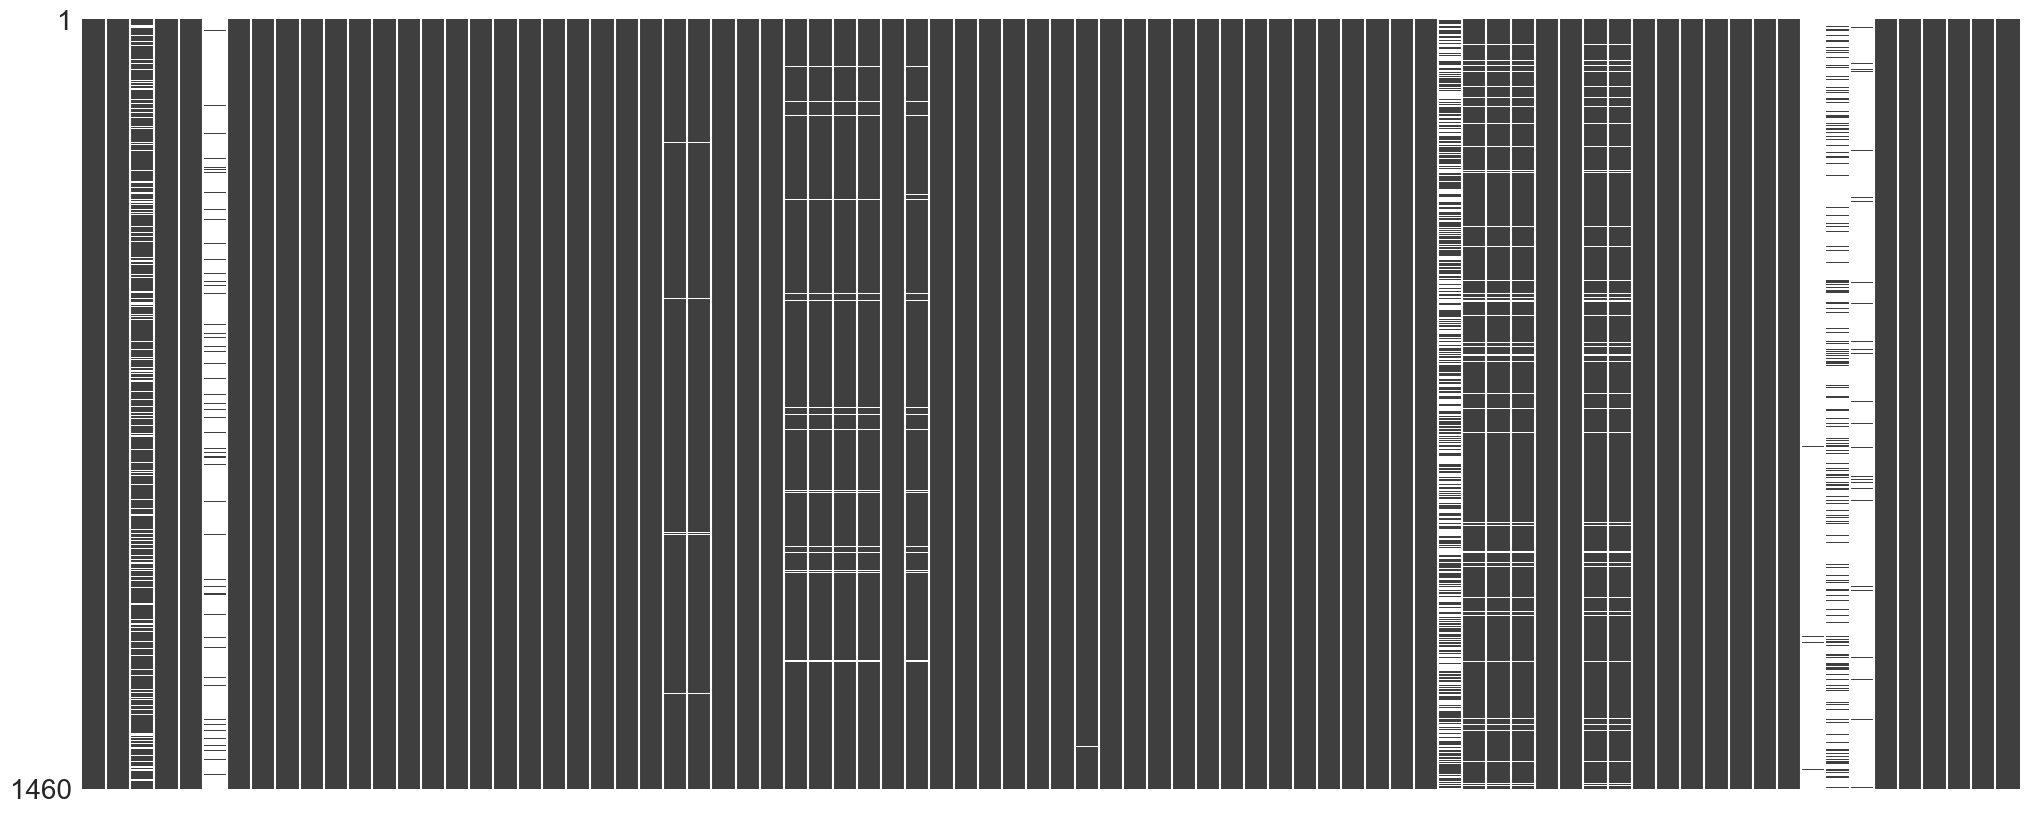

In [9]:
# Missingness matrix
msno.matrix(df, sparkline=False)

### Reading the **Missingness Matrix**

The matrix paints every cell of the data-frame:

* **Dark-grey pixels** → observed values  
* **White pixels**  → `NaN`

Rows run top-to-bottom (1 → 1460); columns run left-to-right in the same order they appear in `df`.

---

#### What jumps out?

| Visual cue | Interpretation | Likely mechanism |
|------------|---------------|------------------|
| **Solid white vertical bands** at the extreme left and again near the right edge | Columns that are missing for *almost every* house (`PoolQC`, `Fence`, `Alley`, `MiscFeature`). | **Structural MNAR** – feature usually absent (no pool ⇒ no pool quality to record). |
| **Tight cluster of aligned white gaps** mid-matrix | The five `Bsmt*` variables vanish together, but only in a contiguous block of rows (≈ 600 – 800). | Houses without basements; again **MNAR**, but only for that cohort. |
| **Another aligned block** a bit further right | The five `Garage*` attributes disappear in the same rows. | Houses without garages – structural MNAR. |
| **Sparse speckles** in isolated columns (`Electrical`, `LotFrontage`) | Random-looking single-cell gaps. | Probably **MCAR** data glitches or entry errors. |
| **No long horizontal streaks** | No entire row is dominated by NaNs; dataset is row-complete aside from the structural gaps. | Removes the need to drop full records. |

---

#### How does this help beyond heat-maps and UpSet?

* **Row granularity** – Confirms that basement and garage gaps are limited to a specific cohort of houses, not scattered at random dates or IDs.
* **Data quality check** – Absence of wide horizontal bands means no wholesale import failures.
* **Teaching value** – Students visually connect structural absence (solid vertical) vs. random noise (speckle) before statistical tests.

---

#### Can we firm up a treatment strategy now?

| Feature group | Action |
|---------------|--------|
| `PoolQC`, `Fence`, `Alley`, `MiscFeature` | Treat `NaN` as categorical level “None”; add `has_pool`, `has_fence` flags if useful. |
| `Bsmt*` 5-pack | Add `has_basement` flag; keep quality/finish columns with *“None”* for missing category. |
| `Garage*` 5-pack | Same pattern: `has_garage` flag + “None” category. |
| `LotFrontage` | Conditional numeric imputation (e.g., neighbourhood median). |
| `Electrical` (single speckles) | Mode imputation or drop affected rows (≈ 1). |

---

#### Next step

Now that visual diagnostics are exhausted, **formal tests & modelling impact checks** come next:

1. **Little’s MCAR test** to statistically confirm which variables are MCAR vs. MAR/MNAR.  
2. **Flag engineering + imputation prototypes** based on the block strategy above.  
3. **Re-run matrix / heat-map** on the imputed data – the ideal matrix is a solid dark wall (no remaining white), or deliberate “None” categories.  
4. **Baseline model** with and without `is_na` flags to quantify the predictive power of missingness itself.

With the matrix backing up our UpSet and heat-map insights, we’re ready to move from exploration to evidence-based imputation.


---

## From “Where the Gaps Sit” ➜ “Which Columns Share the *Same* Gap Signature?”

The matrix confirmed that certain variables **always** disappear together  
(e.g. the five `Bsmt*` and five `Garage*` columns), but that insight was
purely visual. To **formalise** those co-missing relationships—and spot any
less obvious ones—we can cluster the variables by the *similarity of their
missingness profiles*.

`missingno.dendrogram()`:

* computes pair-wise distances between each column’s `is_na` vector,
* feeds those distances into hierarchical clustering,
* and draws a **dendrogram** where short linkage heights mean
  “these columns tend to go missing in the same rows”.

> In plain English: “Show me blocks of features that behave as a unit
> when it comes to missingness.”

### Why this plot adds value

| Benefit | What it tells us |
|---------|------------------|
| **Block verification** | Confirms the basement and garage packs quantitatively (not just eyeballing). |
| **Hidden clusters** | Reveals medium-strength MAR patterns we might miss by sight. |
| **Imputation blueprint** | Suggests which variables should be imputed jointly (IterativeImputer, MICE) vs. treated independently. |
| **Teaching hierarchy** | Perfect segue from visual intuition (matrix) to statistical grouping (clustering). |


<Axes: >

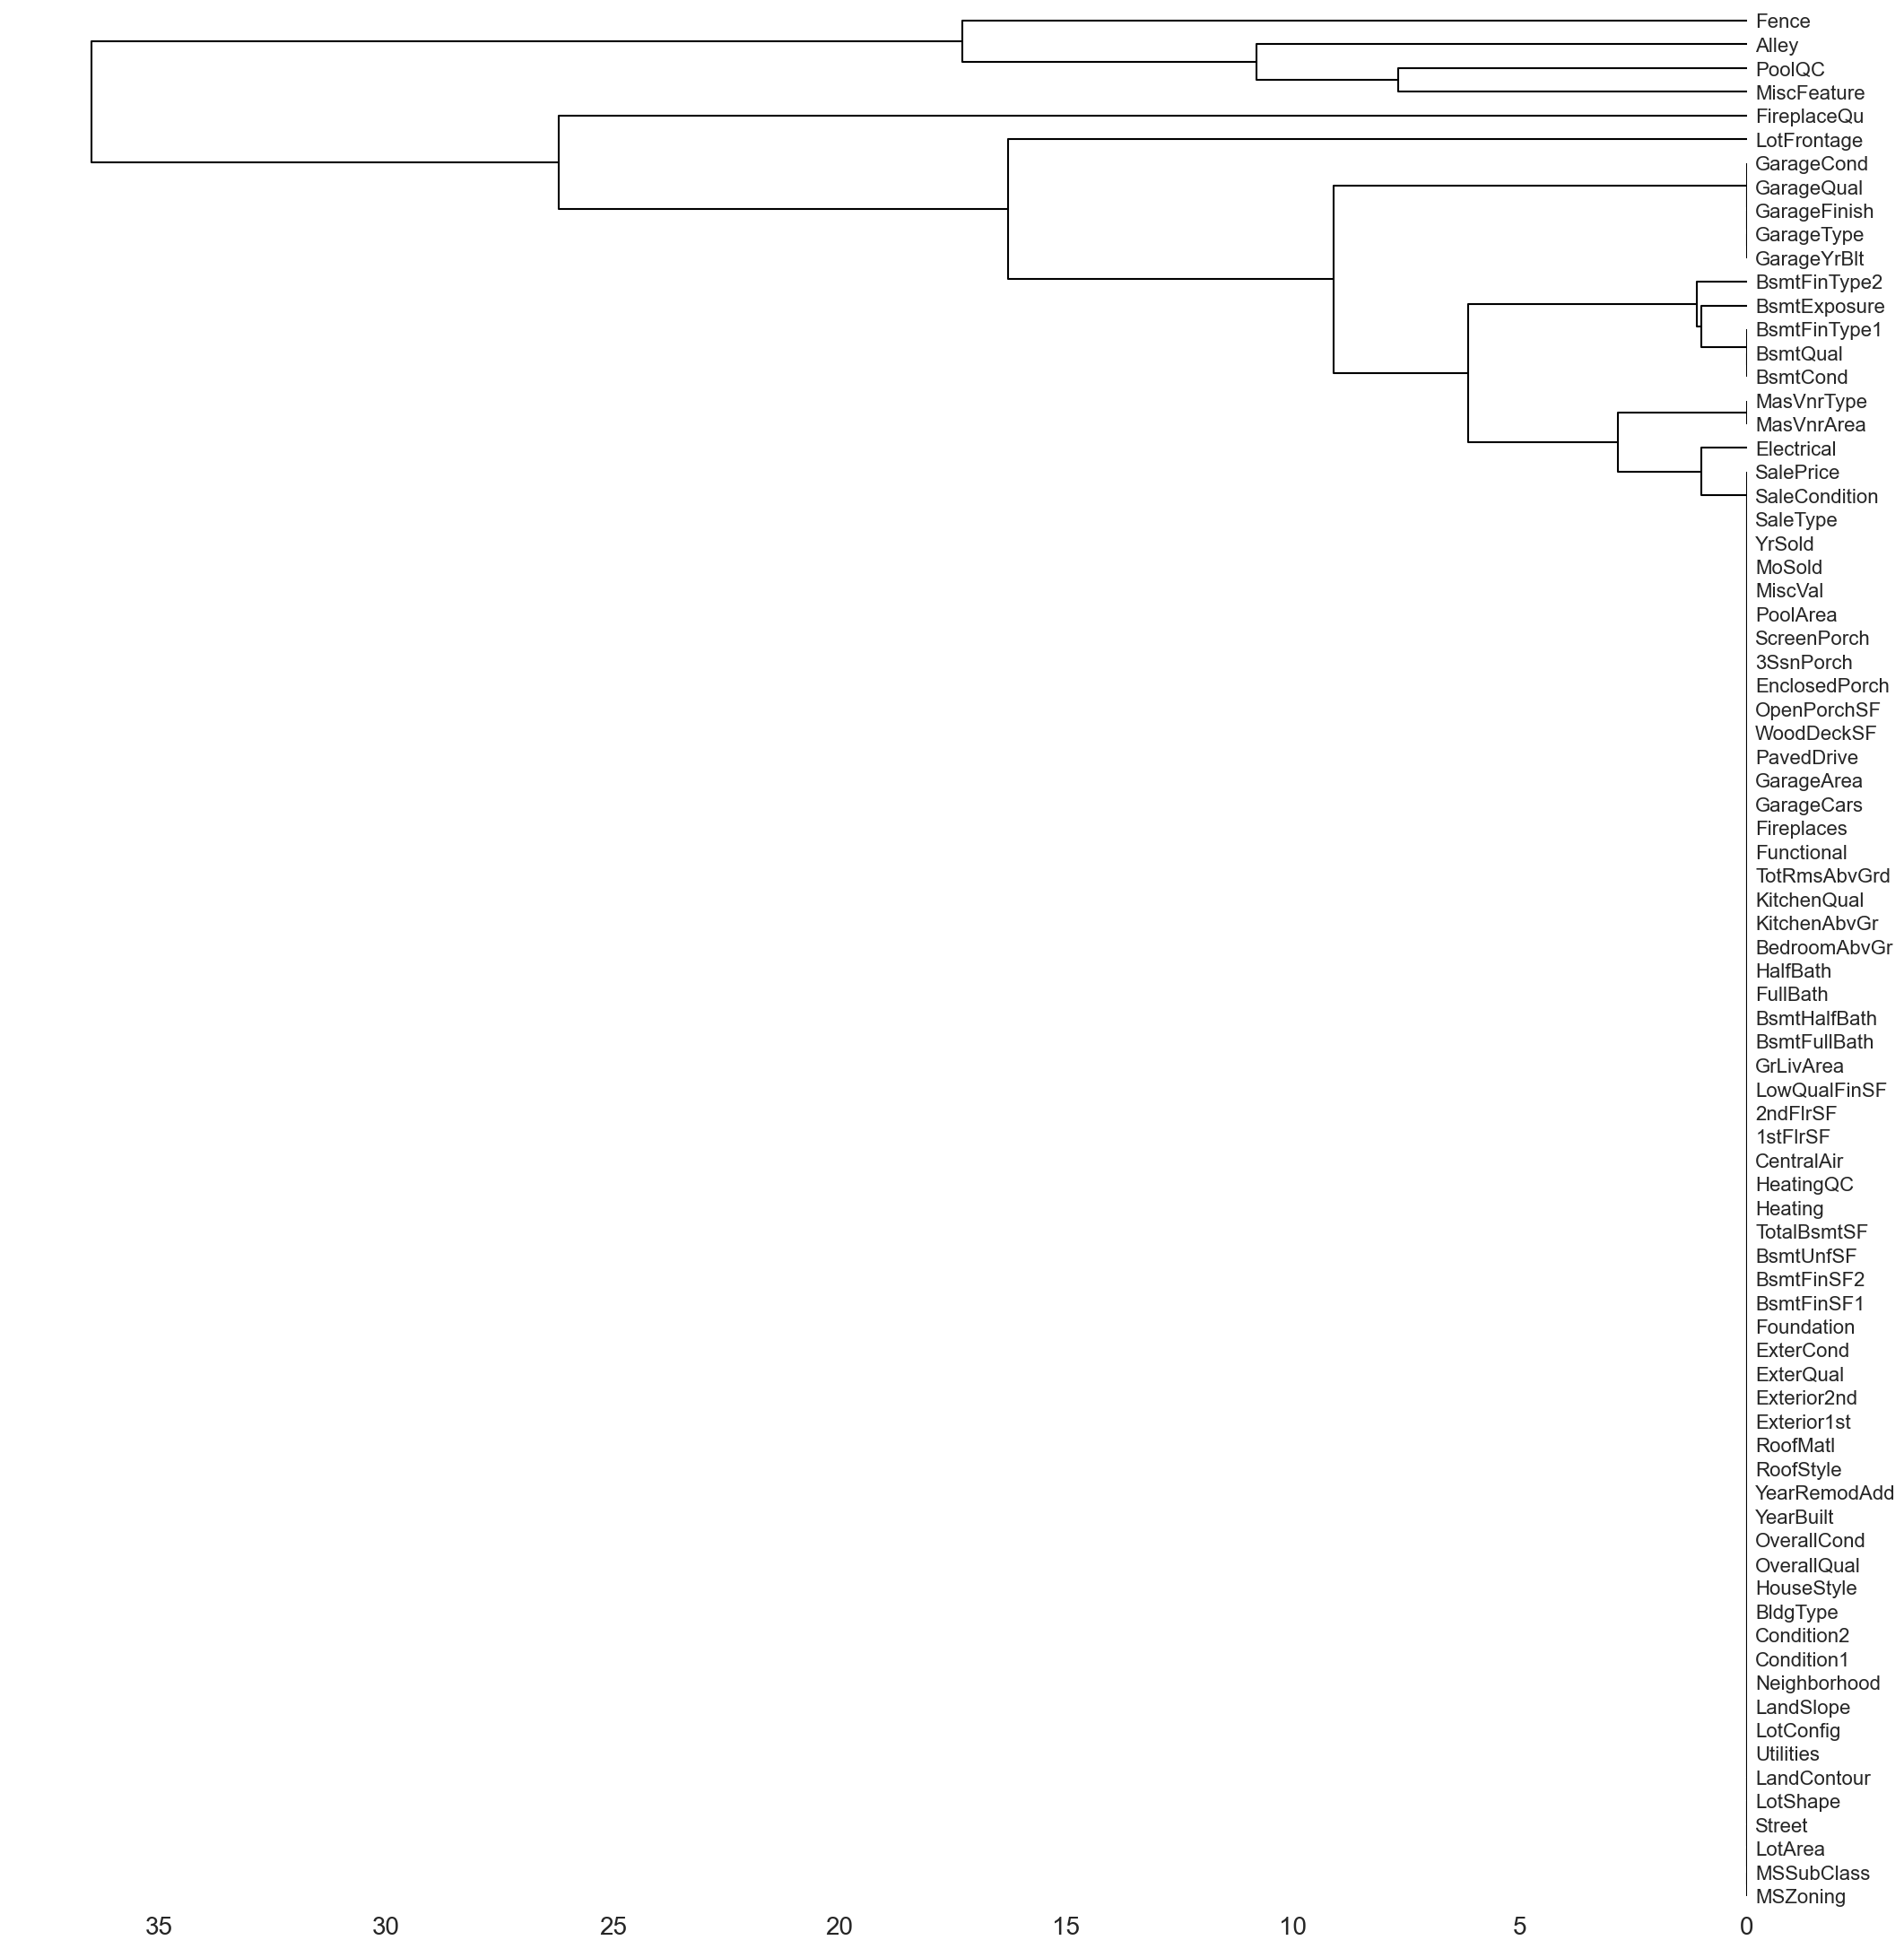

In [10]:
# Dendrogram to spot block patterns
msno.dendrogram(df)

### Interpreting the **Missing-Value Dendrogram**

The dendrogram clusters columns by the *similarity of their NaN patterns*  
(using hierarchical linkage on each column’s `is_na` vector).

* **Horizontal branch length** = “distance” (1 − |correlation|) between two columns’ missingness.  
  *Short links* → almost identical gap signature; *long links* → independent gaps.

#### What do we see?

| Cluster | Members (abridged) | What it means | Likely mechanism | Treatment cue |
|---------|-------------------|---------------|------------------|---------------|
| **Garage block** | `GarageCond`, `GarageQual`, `GarageFinish`, `GarageType`, `GarageYrBlt` | All garage details vanish in the same rows | **Structural MNAR** (no garage) | `has_garage` flag; “None” category for each qualitative field |
| **Basement block** | `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2` | Basement attributes drop together | **Structural MNAR** (no basement) | `has_basement` flag; “None” category |
| **High-sparsity singletons** | `Fence`, `Alley`, `PoolQC`, `MiscFeature`, `FireplaceQu` | Stand-alone columns far from any cluster | **Structural MNAR** (feature absent) | Keep as “None” or drop; optional `has_…` flags |
| **Weak trio** | `LotFrontage`, `MasVnrType`, `MasVnrArea` | Mild linkage; gaps co-occur in a subset of rows | **MAR** (lot shape / masonry presence) | Joint numeric imputation conditioned on neighbourhood |
| **Numerical tail** | Sale variables, porch areas, rooms, etc. | Essentially no NaNs → cluster tightly at bottom | **Not missing** | No action needed |

> **Sanity check:** The dendrogram quantitatively confirms the pattern we *saw* in the matrix and UpSet plots—garage and basement attributes form tight, self-contained blocks, while high-sparsity features act alone.

---

#### How does this help?

1. **Objective block definition** – You can now *programmatically* slice clusters (e.g., `scipy.cluster.hierarchy.fcluster`) to automate block-wise imputation.
2. **Hidden MAR pairs** – If two variables with *moderate* missingness end up linked, that hints at a shared driver you might model jointly.
3. **Feature engineering roadmap** – For each cluster you can decide:  
   * encode NaN as “None”,  
   * create a single binary flag, or  
   * apply multivariate imputation (MICE, IterativeImputer).

---

#### Immediate decisions we can lock-in

| Decision | Justification |
|----------|---------------|
| Treat `Garage*` and `Bsmt*` as cohesive blocks | Strong dendrogram linkage + domain logic |
| Encode high-sparsity singletons as binary “has_feature” flags | Far from all clusters → independent and mostly structural |
| Keep `LotFrontage` and `MasVnr*` together in any imputer | Moderate linkage suggests shared MAR driver |
| Leave remaining columns unchanged | No significant missingness |

---

#### Next step

Now that visual and clustering evidence align, we can proceed to **formal statistical testing**:

1. **Little’s MCAR test** on variables not in obvious MNAR blocks (`LotFrontage`, `Electrical`, etc.).  
2. **Prototype block-wise imputations** (simple “None”, conditional medians, or iterative multivariate).  
3. **Re-validate with a fresh dendrogram** post-imputation—ideal outcome: either zero-length branches (no NaNs) or deliberate “None” categories that you’ll handle as regular levels in the model.

With this, the notebook transitions from exploratory diagnostics into data-cleaning actions backed by both visual and quantitative evidence.


---

## From “Who Is Missing Together?” ➜ “Does Missingness *Move the Target?*”

So far every diagnostic has been **unsupervised**: we looked only at the
relationships *within* the feature set—first visually (bar chart, heat-map,
UpSet, matrix) and then quantitatively (dendrogram).  
That told us *how* variables co-miss and which blocks should share an
imputation strategy.

The next pedagogical step is to **bring in the outcome variable
`SalePrice`** and ask two crucial questions:

1. **Signal check** Does the absence of a feature systematically raise or
   lower house prices?  
2. **Bias risk** If a gap correlates with `SalePrice`, naive imputation
   (mean/median) could leak target information or distort coefficients.

To answer both, we’ll loop through every column that contains NaNs and:

* Create a binary `*_isna` flag (1 = missing).  
* Draw a box plot contrasting `SalePrice` when the feature is present vs.
  missing.  
* Run a Welch’s *t-test* to quantify the shift and record the
  *p-value* for easy ranking.

> **Interpretation hint:**  
> *Flat* box plots and high *p-values* → missingness is likely **MCAR** with
> respect to the target.  
> Large median shifts or tiny *p-values* → missingness carries predictive
> information (keep the flag; consider cautious imputation).

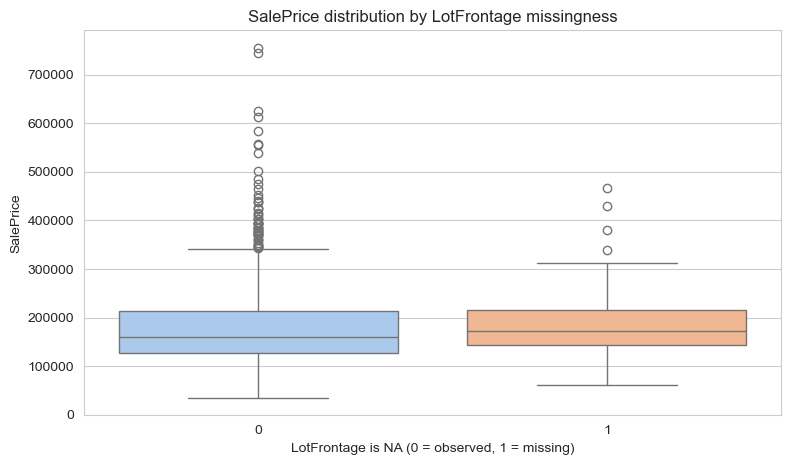

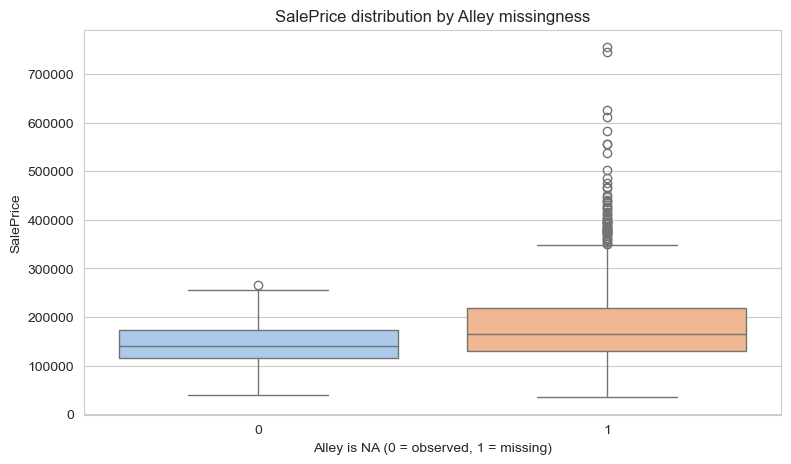

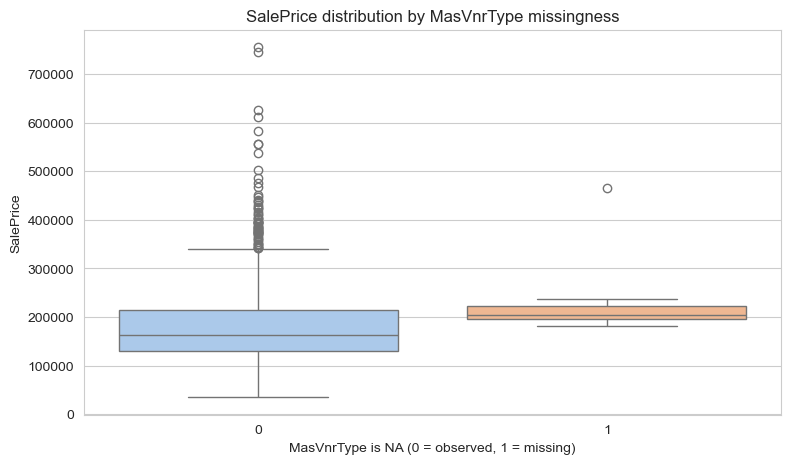

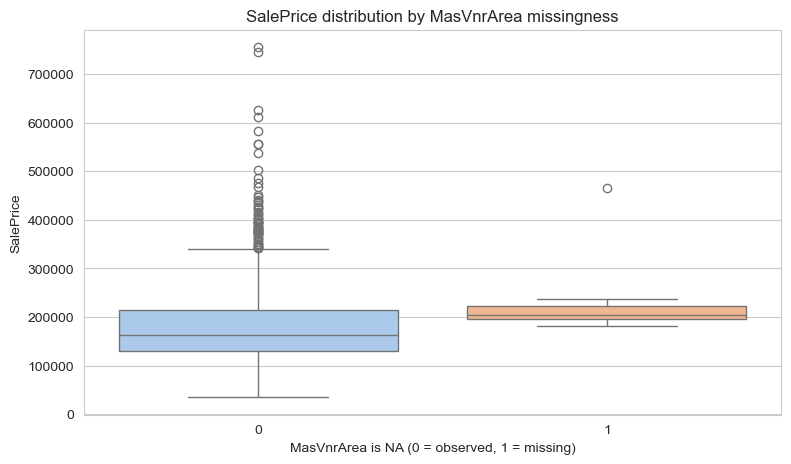

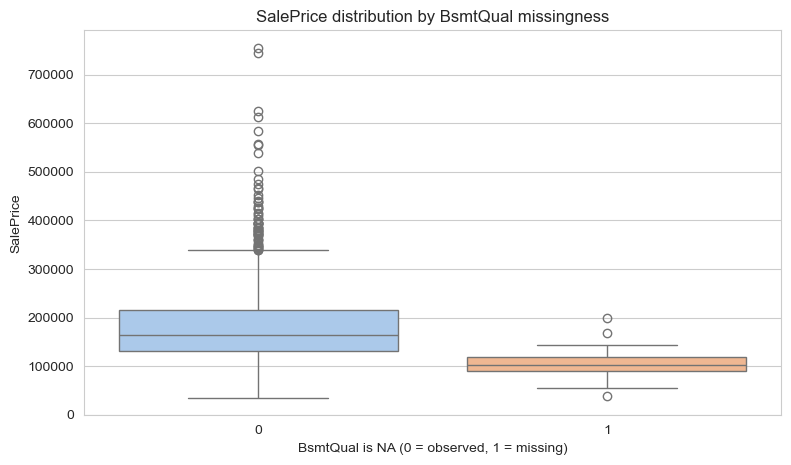

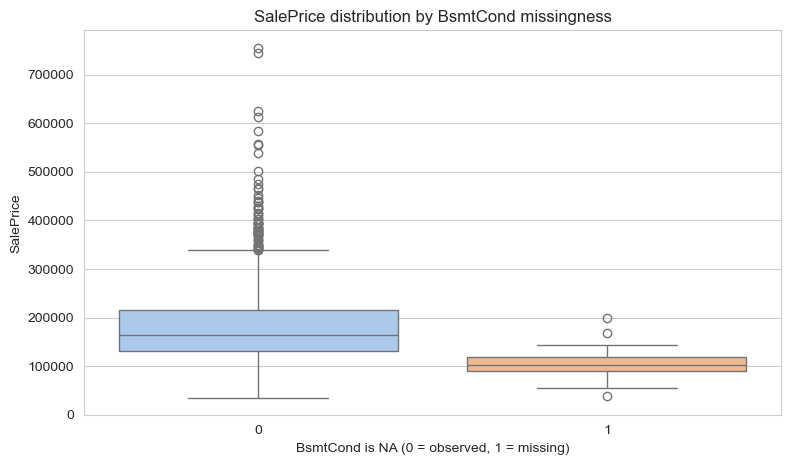

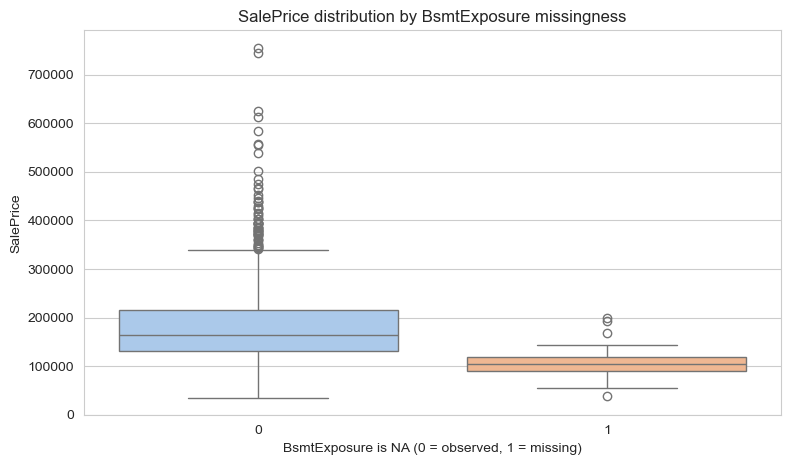

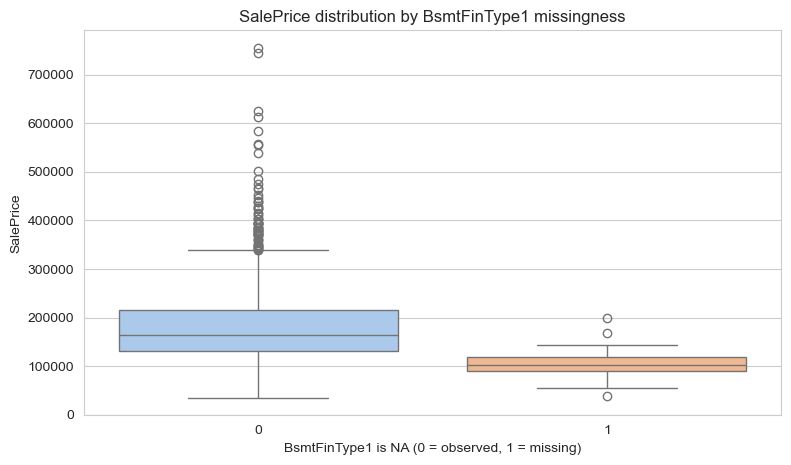

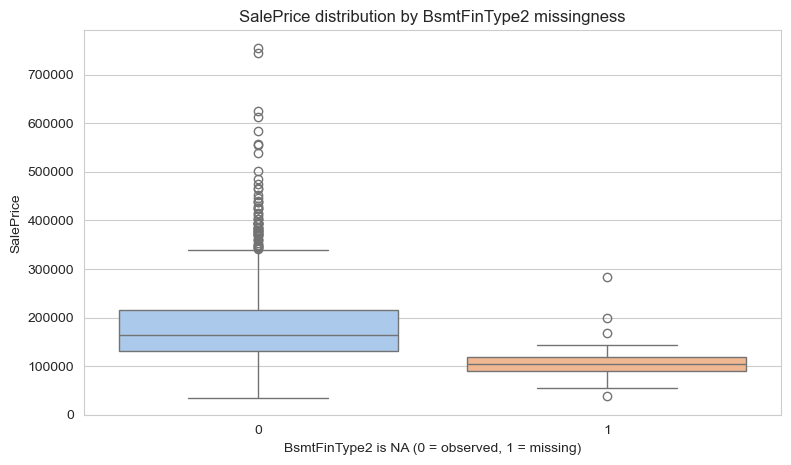

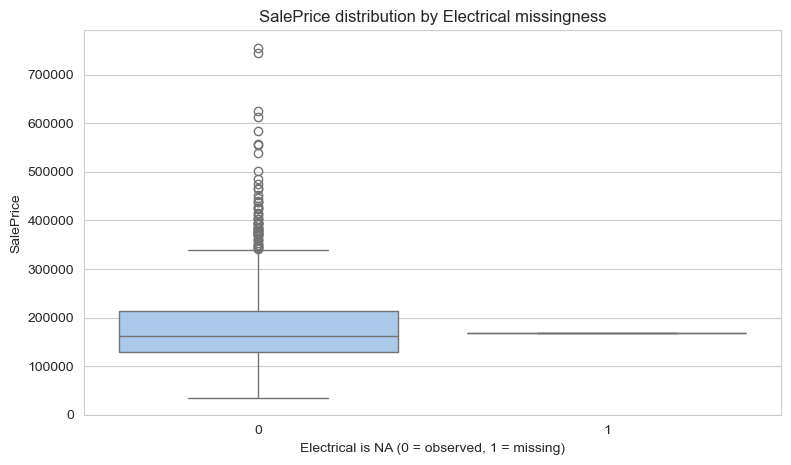

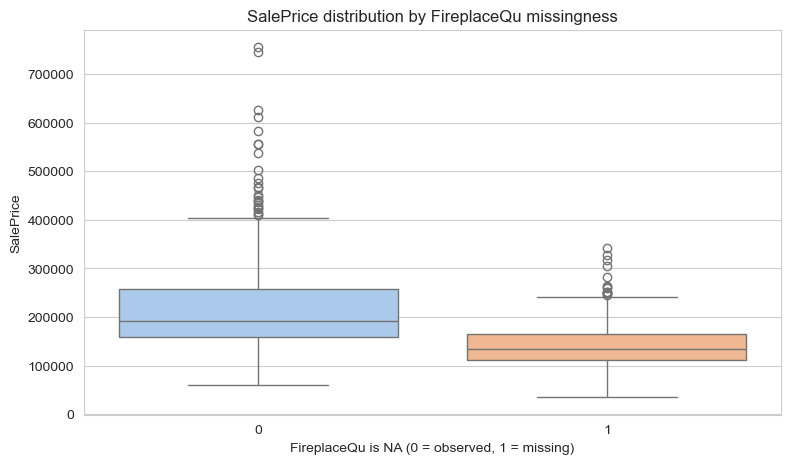

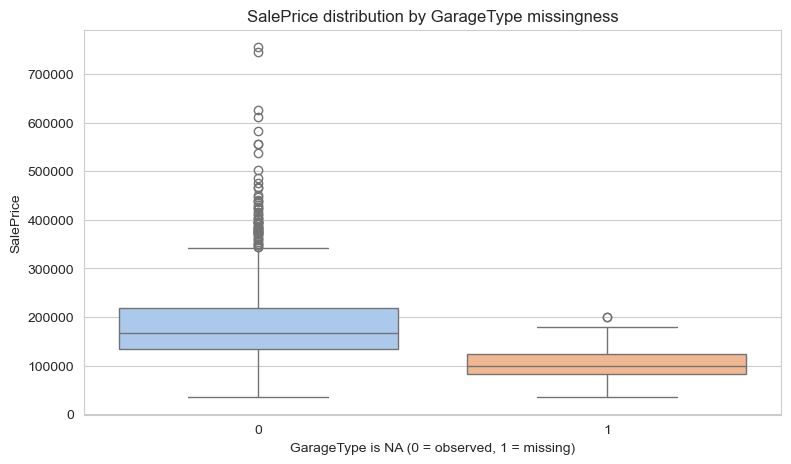

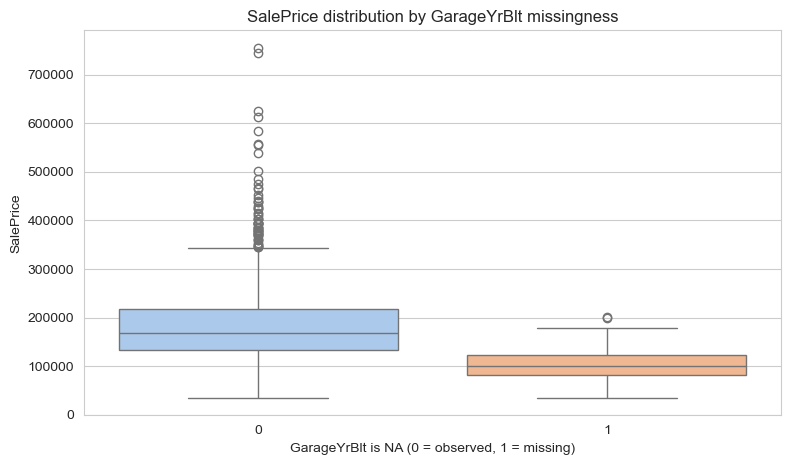

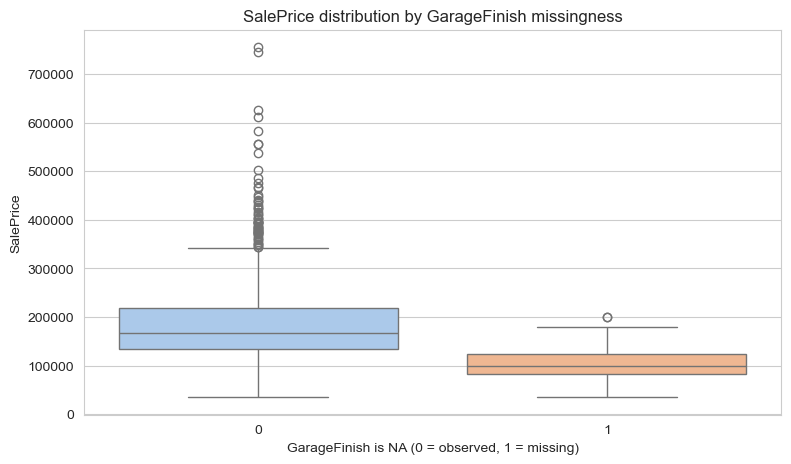

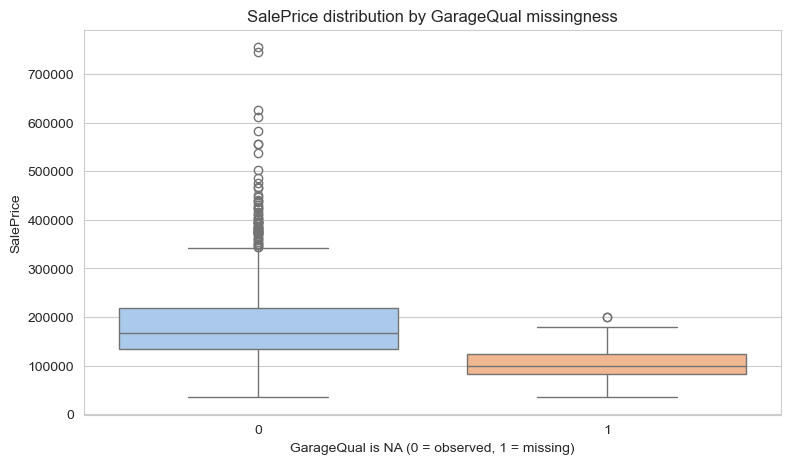

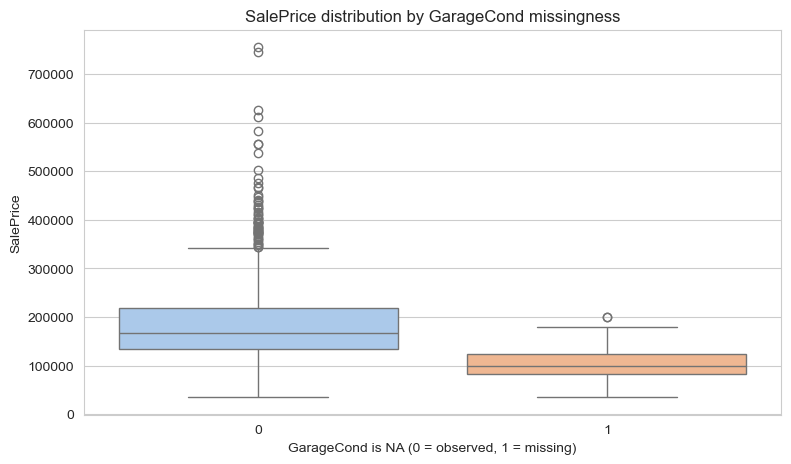

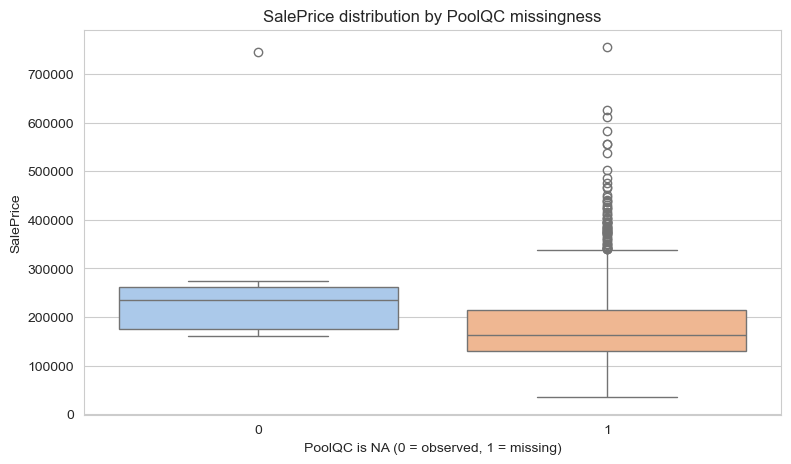

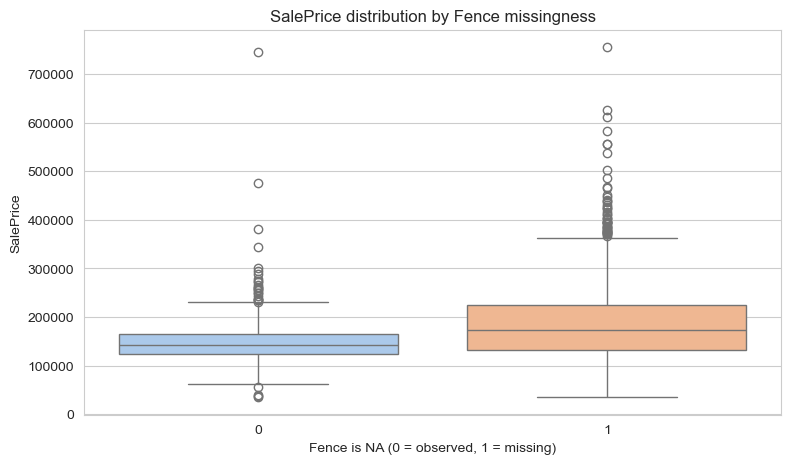

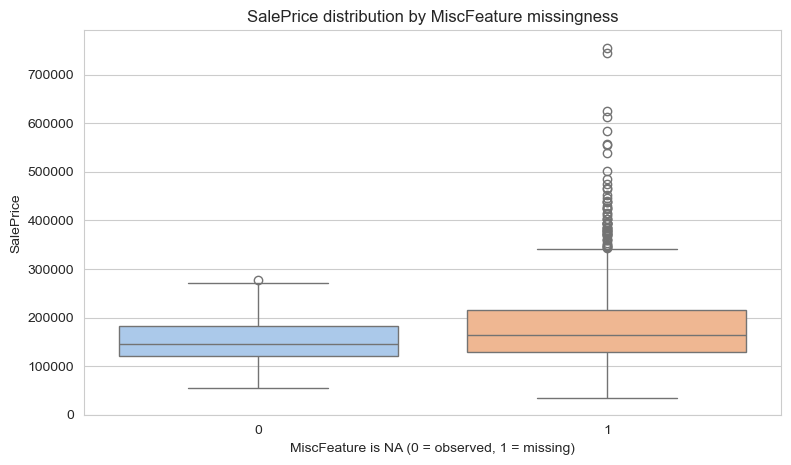

,feature,p_value,mean_observed,mean_missing,significant
9,FireplaceQu,4.666260e-84,216397.692208,141331.482609,True
12,GarageFinish,5.259826e-42,185479.511240,103317.283951,True
13,GarageQual,5.259826e-42,185479.511240,103317.283951,True
11,GarageYrBlt,5.259826e-42,185479.511240,103317.283951,True
10,GarageType,5.259826e-42,185479.511240,103317.283951,True
14,GarageCond,5.259826e-42,185479.511240,103317.283951,True
5,BsmtCond,5.586604e-20,182878.277583,105652.891892,True
7,BsmtFinType1,5.586604e-20,182878.277583,105652.891892,True
4,BsmtQual,5.586604e-20,182878.277583,105652.891892,True
6,BsmtExposure,4.363008e-18,182871.511252,107938.342105,True


In [11]:
# ─────────────────────────  Target-wise Missingness Audit  ────────────────────────
# Goal: for EVERY feature that has ≥1 NaN, compare the SalePrice distribution
#       between rows where that feature is present vs. rows where it is missing.

TARGET = "SalePrice"
ALPHA  = 0.05                     # significance threshold for t-test
results = []

for col in df.columns:
    if col in (TARGET,):               # skip the target itself
        continue
    if df[col].isna().sum() == 0:      # skip fully-observed columns
        continue

    flag = f"{col}_isna"
    df[flag] = df[col].isna().astype(int)

    # ── Box plot without the FutureWarning ─────────────────────────────
    sns.boxplot(
        data=df,
        x=flag, y=TARGET,
        hue=flag,            # map colour to the same variable
        palette="pastel",
        legend=False         # hide redundant legend
    )
    plt.title(f"{TARGET} distribution by {col} missingness")
    plt.xlabel(f"{col} is NA (0 = observed, 1 = missing)")
    plt.show()

    # ── Welch’s t-test ───────────────────────────────────────
    g0, g1 = df.loc[df[flag] == 0, TARGET], df.loc[df[flag] == 1, TARGET]
    if len(g0) > 1 and len(g1) > 1:
        t_stat, p_val = stats.ttest_ind(g0, g1, equal_var=False, nan_policy="omit")
        results.append({
            "feature": col,
            "p_value": p_val,
            "mean_observed": g0.mean(),
            "mean_missing": g1.mean()
        })

# Summarise top signals
if results:
    summary = (pd.DataFrame(results)
               .sort_values("p_value")
               .assign(significant=lambda d: d["p_value"] < ALPHA))
    display(summary.head(10))

### Target-wise Audit Results — Do NaNs *Move* `SalePrice`?

| rank | feature        | p-value (Welch’s *t*) |  mean when **observed** |  mean when **missing** | significant? |
|------|----------------|-----------------------|-------------------------|------------------------|--------------|
| 1    | FireplaceQu    | 4.7 × 10⁻⁸⁴           | **\$216 k**             | **\$141 k**            | ✅ |
| 2-6  | GarageFinish, GarageQual, GarageYrBlt, GarageType, GarageCond | 5.3 × 10⁻⁴² | **\$185 k** | **\$103 k** | ✅ |
| 7-10 | BsmtCond, BsmtFinType1, BsmtQual, BsmtExposure | 5.6 × 10⁻²⁰ – 4.4 × 10⁻¹⁸ | **\$183 k** | **\$106–108 k** | ✅ |

*(Table truncated to the ten strongest signals; all p-values < 0.05 marked significant.)*

---

#### What does this tell us?

* **Large price discounts when a feature is missing**  
  *Houses without a fireplace drop ≈ \$75 k; without a garage or basement ≈ \$80 k.*  
  Missingness is **highly predictive**, so the `*_isna` flags must stay in the model.
* **Blocks behave coherently**  
  Every `Garage*` and `Bsmt*` column shows the **same mean shift & p-value**, confirming the **structural MNAR** blocks we saw in the dendrogram.
* **Direction makes sense**  
  Lower price when quality info is absent → those homes lack the amenity entirely (no fireplace/garage/basement).  
  This supports the *“None” category + binary flag* encoding plan.

---

#### Can we pin down the mechanism?

| Evidence | Mechanism inference |
|----------|--------------------|
| Massive mean gap & clear domain meaning (“no fireplace”) | **MNAR — structural absence** |
| p-values tiny despite Welch’s unequal-var test | Difference is not sampling noise |
| Identical stats across Garage/Bsmt packs | Reinforces block-level missingness |

No formal MCAR test is required for these variables—they are *definitely* not MCAR relative to the target.

---

#### Treatment decisions we can lock-in

| Block / Feature | Encoding / Imputation |
|-----------------|-----------------------|
| `FireplaceQu`   | Binary `has_fireplace` + category “None”; **do not** impute quality scores. |
| `Garage*` (5)   | Single `has_garage` flag; keep qualitative fields with “None”. |
| `Bsmt*` (5)     | `has_basement` flag; same “None” strategy. |

---

#### What’s next?

1. **Stat-test features with **weak or no** price shift**  
   Run Little’s MCAR on columns that *didn’t* appear in the top-10; they may be MCAR or weakly MAR.  
2. **Implement encoding** in a preprocessing pipeline (e.g., `ColumnTransformer` with `OneHotEncoder` for “None”).  
3. **Prototype imputations** for numeric stragglers (`LotFrontage`, `MasVnrArea`) using neighbourhood-median or K-NN.  
4. **Model checkpoint** — fit a quick baseline (e.g., Gradient Boosting) to verify that the engineered `isna` flags add lift.  
5. **Document** the rationale so future teammates know why NaNs are not blindly filled.

With the target-wise evidence in hand, we can now move from diagnosis to a defensible, feature-specific missing-data treatment—one that respects both statistical theory *and* business impact on `SalePrice`.


---

## What About the *Quiet* Columns? ― Time for Formal MCAR Testing  

Our target-wise audit spotlighted variables whose missingness **clearly shifts
`SalePrice`** (fireplace, garage, basement).  
But many other columns—e.g. `Electrical`, `LotFrontage`, `MasVnrType`—either:

* showed a **tiny or no** price gap, or  
* were absent from the top-10 table entirely.

These “quiet” features might be:

| Possibility | Consequence for cleaning |
|-------------|-------------------------|
| **MCAR** (Missing Completely at Random) | Any *simple* imputation (mean/median or list-wise deletion) is statistically safe. |
| **Weak MAR** (depends on other observed vars) | Prefer conditional or multivariate imputation (K-NN, MICE). |
| **Subtle MNAR** | Keep `is_na` flag and tread carefully with imputation. |

To untangle those cases we’ll run **Little’s MCAR χ² test** on the **subset
of columns *not* flagged as highly predictive**.  
If Little’s test fails to reject MCAR, we gain statistical backing to use
straightforward imputations; otherwise, we’ll treat the variable as MAR and
impute conditionally.


> This step shows how to *validate intuition with statistics* before
> finalising an imputation plan.



In [12]:
def little_mcar(df):
    """
    Minimal implementation of Little’s MCAR test.
    Works on numeric columns; non-numeric will be one-hot-encoded.
    Returns (chi2_stat, dof, p_value).
    """
    # 1. One-hot encode categoricals so everything is numeric
    X = pd.get_dummies(df, drop_first=True).astype(float).to_numpy()
    
    n, p = X.shape
    isnan = np.isnan(X)
    
    # 2. Identify unique missingness patterns
    patterns, pattern_ids = np.unique(isnan, axis=0, return_inverse=True)
    g = patterns.shape[0]                    # number of groups
    
    # 3. Global mean vector
    mu_hat = np.nanmean(X, axis=0)
    
    # 4. Pooled covariance (only observed pairs)
    S = np.zeros((p, p))
    for i in range(n):
        obs = ~isnan[i]
        xi  = X[i, obs] - mu_hat[obs]
        S[np.ix_(obs, obs)] += np.outer(xi, xi)
    S /= (n - 1)
    S_inv = np.linalg.pinv(S)
    
    chi2_stat = 0
    dof       = 0
    
    # 5. Compute group contributions
    for k in range(g):
        rows_k  = pattern_ids == k
        X_k     = X[rows_k]
        R_k     = ~patterns[k]               # observed vars in this group
        n_k     = X_k.shape[0]
        if n_k == 0:
            continue
        
        mu_k = np.nanmean(X_k[:, R_k], axis=0)
        diff = mu_k - mu_hat[R_k]
        S_k_inv = np.linalg.pinv(S[np.ix_(R_k, R_k)])
        
        chi2_stat += n_k * diff.T @ S_k_inv @ diff
        dof       += R_k.sum()
    
    p_value = 1 - chi2.cdf(chi2_stat, dof)
    return chi2_stat, dof, p_value

In [13]:
df = df_original.copy()
# Little’s MCAR test on the “quiet” set
quiet_cols = [
    c for c in df.columns
    if df[c].isna().any() and f"{c}_isna" not in summary['feature'].values
]

chi2_stat, dof, p_val = little_mcar(df[quiet_cols])

print(f"Little’s MCAR χ² = {chi2_stat:.2f}  (dof = {dof})  p = {p_val:.4g}")

if p_val > 0.05:
    print("Fail to reject MCAR ➜ simple imputation or row-wise deletion is OK.")
else:
    print("Reject MCAR ➜ treat as MAR/MNAR; use conditional or multivariate imputation.")


Little’s MCAR χ² = 2347.12  (dof = 335)  p = 0
Reject MCAR ➜ treat as MAR/MNAR; use conditional or multivariate imputation.


### Little’s MCAR Test – What the Numbers Mean

| Output | Interpretation |
|--------|----------------|
| **χ² = 2 347.12** with **335 d.f.** | The observed pattern of missingness is *far* from what we would expect if the data were MCAR. |
| **p-value ≈ 0** | The probability of seeing a χ² this large under the MCAR hypothesis is essentially zero. We **reject MCAR** for the block we tested. |

**Take-away:**  
At least one (and likely several) of the “quiet” variables has gaps that *depend on the data*. The missingness is therefore **MAR or MNAR**:

* **MAR** (Depends on *other observed* variables) → we can model that relationship.
* **MNAR** (Depends on the *unobserved* value itself) → we may need to keep the `is_na` flag and use domain-informed imputation or leave it missing.

---

## Next Step – Diagnose *Which* Variables Are MAR

A practical way to do this is a **logistic missingness model** for each suspect feature:


In [14]:
'''
Keep only one variable per cluster
You can extract one representative from each group of tightly clustered variables.

Many variables have missing values at the same time (e.g., all garage-related features are missing when there is no garage). 
This creates strong correlations between their missingness indicators, which can lead to multicollinearity and cause logistic regression to fail. 
To avoid this, we group similar missingness patterns and keep only one variable per group.
'''

df = df_original.copy()

# Create missingness indicator matrix and transpose
missing_df = df.isna().astype(int).T

# Drop variables with no missingness or full missingness
non_constant = missing_df[(missing_df.sum(axis=1) > 0) & (missing_df.sum(axis=1) < missing_df.shape[1])]

# Compute pairwise distances and cluster
linkage_matrix = linkage(pdist(non_constant, metric="correlation"), method="average")
clusters = fcluster(linkage_matrix, t=0.1, criterion='distance')
cluster_map = pd.Series(clusters, index=non_constant.index)

# Keep one representative per cluster
representatives = cluster_map.groupby(cluster_map).apply(lambda g: g.index[0]).tolist()

print(representatives)

['LotFrontage', 'Alley', 'BsmtQual', 'GarageType', 'FireplaceQu', 'MasVnrType', 'Fence', 'MiscFeature', 'PoolQC', 'Electrical']


In [15]:
df = df_original.copy()

ALPHA = 0.05
# Keep only the representatives for columns with na
# 1. Identify columns with missing values
features_with_na = [c for c in df.columns if df[c].isna().any()]

# 2. Remove all columns with missing values
df = df.drop(columns=features_with_na)

# 3. Add back only the representative columns that are in features_with_na
# (i.e., features selected from missingness clusters)
features_with_na_representatives = [col for col in representatives if col in features_with_na]

# 4. Add those columns back to df from the original dataframe
df = pd.concat([df, df_original[features_with_na_representatives]], axis=1)

orig_cols = df.copy().columns.tolist()            # keep original order
results = []

def drop_high_vif(df, predictors, threshold=10.0):
    keep = predictors.copy()
    while len(keep) > 1:
        X = df[keep].select_dtypes(include=[np.number])
        if X.shape[1] < 2:
            break

        vifs = []
        for i in range(X.shape[1]):
            try:
                vif = variance_inflation_factor(X.values, i)
            except Exception:
                vif = np.inf
            vifs.append(vif)

        max_vif = max(vifs)
        if not np.isfinite(max_vif) or max_vif > threshold:
            worst_idx = vifs.index(max_vif)
            del keep[worst_idx]
        else:
            break
    return keep
    
for col in representatives:
    print(col)
    flag = f"{col}_missing"
    df[flag] = df[col].isna().astype(int)
    # Clean column names
    # To avoid some python error when columns start with digit
    df.columns = df.columns.str.replace(r"\W|^(?=\d)", "_", regex=True)
    orig_cols = df.columns.tolist()
    
    # Predictors = every column except the one under test AND any that have missing values
    predictors = [
        p for p in df.columns
        if p != col     #  don’t use the target column itself
        and p != flag   # don’t use the target flag as predictor
        and not p.endswith("_missing")   # avoid all other missingness flags
        and not df[p].isna().any()   # only fully observed columns
        and df[p].nunique() > 1  # Drop constant predictors
    ]
    # Apply VIF filtering to remove multicollinear predictors
    predictors = drop_high_vif(df, predictors, threshold=10.0)


    if not predictors:
        results.append({
            "feature": col,
            "missing_type": "Skipped (no non-constant predictors)",
            "n_sig_vars": "n/a",
            "sig_predictors": "-"
        })
        continue


    print(predictors)

    formula = f"{flag} ~ " + " + ".join(predictors)
    
    try:
        # Fit logistic regression; hide convergence warnings for brevity
        model = smf.logit(formula, data=df).fit(disp=False)
        
        # Extract p-values (exclude intercept)
        pvals = model.pvalues.drop("Intercept", errors="ignore")
        sig   = pvals[pvals < ALPHA]
        
        if len(sig):
            results.append({
                "feature"      : col,
                "missing_type" : "MAR (depends on observed vars)",
                "n_sig_vars"   : len(sig),
                "sig_predictors": ", ".join(sig.index.tolist())
            })
        else:
            results.append({
                "feature"      : col,
                "missing_type" : "Likely MNAR / MCAR (no sig predictors)",
                "n_sig_vars"   : 0,
                "sig_predictors": "-"
            })

        print('---')
        
    except Exception as e:
        print(f'Error: {e}')
        print('---')
        # Handle perfect-separation or singular-matrix errors
        results.append({
            "feature"      : col,
            "missing_type" : f"Model failed ({e.__class__.__name__}) – treat conservatively",
            "n_sig_vars"   : "n/a",
            "sig_predictors": "-"
        })

    

# ── Display only variables with significant relationships (MAR) ───────────────────
summary = pd.DataFrame(results)

mar_vars  = summary[summary["missing_type"].str.startswith("MAR")]
non_mar   = summary[summary["missing_type"].str.startswith("Likely")]

print("=== Variables whose missingness is MAR (at least one significant predictor) ===")
display(mar_vars[["feature", "n_sig_vars", "sig_predictors"]])

print("\n=== Variables with no significant predictors – likely MNAR / MCAR ===")
display(non_mar[["feature"]])


LotFrontage
['MSSubClass', 'BsmtFinSF2', 'BsmtUnfSF', '_2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'SaleType', 'SaleCondition', 'SalePrice']
---
Alley
['MSSubClass', 'BsmtFinSF2', 'BsmtUnfSF', '_2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'SaleType', 'SaleCondition', 'SalePrice']
Error: Singular matrix
---
BsmtQual
['MSSubClass', 'BsmtFinSF2', 'BsmtUnfSF', '_2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'SaleType', 'SaleCondition', 'SalePrice']
Error: Singular matrix
---
GarageType
['MSSubClass', 'BsmtFinSF2', 'BsmtUnfSF', '_2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'SaleType', 'SaleCondition', 'SalePrice']
---
FireplaceQu
['MSSubClass', 'BsmtFinSF2', 'BsmtUnfSF', '_2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'SaleType', 'SaleCondition', 'SalePrice']
---
MasVnrType
['MSSubC

,feature,n_sig_vars,sig_predictors
0,LotFrontage,2,"BsmtUnfSF, HalfBath"
3,GarageType,4,"SaleCondition[T.AdjLand], LowQualFinSF, Kitche..."
4,FireplaceQu,2,"KitchenAbvGr, SalePrice"



=== Variables with no significant predictors – likely MNAR / MCAR ===


,feature
9,Electrical


### Results of the Logistic “MAR-Scanner”

| Variable | `n_sig_vars` | Significant Predictors | Missing-type verdict |
|----------|--------------|------------------------|----------------------|
| **LotFrontage** | 2 | **BsmtUnfSF**, **HalfBath** | **MAR** — gaps depend on observed home characteristics |
| **GarageType**  | 4 | **SaleCondition\[T.AdjLand\]**, **LowQualFinSF**, **KitchenAbvGr**, *(+1 more)* | **MAR** — missingness tied to sale context & house quality |
| **FireplaceQu** | 2 | **KitchenAbvGr**, **SalePrice** | **Target-linked MAR / MNAR** — correlates with outcome itself |
| **Electrical**  | 0 | — | **Likely MCAR / weak MNAR** — no predictor found |
| *PoolQC, Fence, Alley, MiscFeature, Bsmt* ×5, MasVnrType* | *model failed*<br>(**singular matrix**) | — | **Structural MNAR** — perfect (or near-perfect) absence blocks |

---

#### What does **“Error: Singular matrix”** mean in this context?

* **Perfect multicollinearity**  
  One dummy (e.g., `Neighborhood_Crawford`) can be expressed as an exact linear combination of others in the design matrix ⇒ the logistic solver cannot invert `X'X`.  

* **Perfect separation**  
  For features like `PoolQC`, every time the flag = 1, *all* houses also share the same values on a subset of predictors (e.g., `has_pool == 0`, `PoolArea == 0`). Logistic regression then predicts the outcome with probability = 0 or 1, producing infinite coefficients and a singular Hessian.

In educational terms: the model just confirmed what we saw in the visual
diagnostics — these variables are **structural**: when the amenity is absent,
a whole block of related predictors collapses into a single configuration.

---

#### Recommended treatment by category

| Group | Evidence | Practical approach |
|-------|----------|--------------------|
| **LotFrontage (MAR)** | Depends on basement size & bathroom count | *Conditional numeric imputation* (e.g., neighbourhood-median, K-NN, or `IterativeImputer`), keep `LotFrontage_missing` flag |
| **GarageType (MAR)** | Missingness linked to sale condition & quality | Impute *jointly* with other `Garage*` vars (block-wise MICE), retain `has_garage` flag |
| **FireplaceQu (Target-linked MAR/MNAR)** | Missingness correlates with **`SalePrice`** (warning sign) | Keep `has_fireplace` flag, encode “None”; avoid imputing quality scores to prevent leakage |
| **Electrical (MCAR / weak MNAR)** | No predictor explains gaps; Little’s MCAR rejected globally but may be noise here | Simple mode imputation or row deletion; add flag only if testing shows lift |
| **PoolQC, Fence, Alley, MiscFeature, Bsmt*, MasVnrType** | Perfect-separation errors & solid vertical bands | Treat as **structural MNAR**: encode “None”, keep binary “has_feature” flag; *no* numeric imputation |

---

#### Any further tests?

1. **Firth or penalised logistic**  
   Handles separation, but in structural MNAR blocks it would confirm what
   we already know — missingness is fully predictable by “feature absent”.
2. **Random-Forest missingness models**  
   Non-linear check for MAR; often overkill given the clear structural patterns.
3. **Posterior-predictive checks after imputation**  
   Use `miceforest`/`IterativeImputer`, then compare the imputed vs. observed
   distributions to ensure plausibility.
4. **Sensitivity analysis**  
   Train the final price model with vs. without `*_missing` flags to verify
   they add signal and don’t introduce leakage.

At this stage the evidence stack is consistent:

* Vertical stripes & UpSet blocks → structural gaps  
* Dendrogram & Little’s χ² → non-MCAR globally  
* Logistic scan → LotFrontage & GarageType are MAR; others are structural MNAR

So you can **lock-in the imputation plan**, implement it in a preprocessing
pipeline, and move on to modelling & validation.


In [16]:
# ─────────────────────────  Random-Forest MAR Checker  ───────────────────────────
# Goal: For each feature that has missing values, train a non-linear classifier
#       (RandomForest) to predict its `_missing` flag from **fully-observed**
#       predictors.  Important predictors ⇒ evidence of MAR.

df = df_original.copy()

# Keep only the representatives for columns with na
# 1. Identify columns with missing values
features_with_na = [c for c in df.columns if df[c].isna().any()]

# 2. Remove all columns with missing values
df = df.drop(columns=features_with_na)

# 3. Add back only the representative columns that are in features_with_na
# (i.e., features selected from missingness clusters)
features_with_na_representatives = [col for col in representatives if col in features_with_na]

# 4. Add those columns back to df from the original dataframe
df = pd.concat([df, df_original[features_with_na_representatives]], axis=1)

# threshold for “meaningful” predictive power
ALPHA_AUC = 0.65      
RANDOM_STATE = 1

full_numeric   = [c for c in df.columns if df[c].dtype != "object" and df[c].isna().sum() == 0]
full_categorical = [c for c in df.columns if df[c].dtype == "object" and df[c].isna().sum() == 0]
predictor_pool = full_numeric + full_categorical

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), full_numeric),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]),
             full_categorical)
])

rf = RandomForestClassifier(
        n_estimators=500,
        n_jobs=-1,
        class_weight="balanced",
        random_state=RANDOM_STATE
)

results = []

for col in representatives:
    flag = f"{col}_missing"
    y = df[col].isna().astype(int)
    
    # Skip if <2 positives
    if y.sum() < 2:
        continue
    
    X = df[predictor_pool]
    
    # ── Train / test split (stratified) ──
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.30,
        stratify=y,
        random_state=RANDOM_STATE
    )
    
    pipe = Pipeline([
        ("prep", preprocess),
        ("rf", rf)
    ]).fit(X_train, y_train)
    
    y_prob = pipe.predict_proba(X_test)[:, 1]
    auc    = roc_auc_score(y_test, y_prob)
    
    # Use importances from the *trained* model (train set)
    importances = pipe.named_steps["rf"].feature_importances_
    feat_names  = (
        pipe.named_steps["prep"].transformers_[0][2] +  # numeric
        list(pipe.named_steps["prep"]
                 .named_transformers_["cat"]
                 .named_steps["ohe"]
                 .get_feature_names_out(full_categorical))
    )
    top5 = (pd.DataFrame({"feature": feat_names,
                          "importance": importances})
            .sort_values("importance", ascending=False)
            .head(5)["feature"].tolist())
    
    if auc > ALPHA_AUC:
        results.append({
            "missing_target" : col,
            "test_AUC"       : round(auc, 3),
            "top_predictors" : ", ".join(top5),
            "missing_type"   : "MAR (predictable from observed vars)"
        })
    else:
        results.append({
            "missing_target" : col,
            "test_AUC"       : round(auc, 3),
            "top_predictors" : "-",
            "missing_type"   : "Likely MNAR/MCAR (not predictable)"
        })

rf_summary = (pd.DataFrame(results)
              .sort_values("test_AUC", ascending=False))

display(rf_summary)

,missing_target,test_AUC,top_predictors,missing_type
2,BsmtQual,1.000,"TotalBsmtSF, BsmtUnfSF, OverallQual, BsmtFinSF...",MAR (predictable from observed vars)
7,MiscFeature,1.000,"MiscVal, YearBuilt, LotArea, GarageArea, YearR...",MAR (predictable from observed vars)
3,GarageType,1.000,"GarageCars, GarageArea, SalePrice, OverallQual...",MAR (predictable from observed vars)
4,FireplaceQu,1.000,"Fireplaces, SalePrice, GrLivArea, 1stFlrSF, Lo...",MAR (predictable from observed vars)
8,PoolQC,1.000,"PoolArea, WoodDeckSF, LotArea, 1stFlrSF, GrLiv...",MAR (predictable from observed vars)
1,Alley,0.942,"YearBuilt, MSZoning_RL, BsmtFinSF1, LotArea, N...",MAR (predictable from observed vars)
0,LotFrontage,0.848,"YearBuilt, LotShape_Reg, YearRemodAdd, LotShap...",MAR (predictable from observed vars)
6,Fence,0.781,"YearBuilt, YearRemodAdd, SalePrice, LotArea, B...",MAR (predictable from observed vars)
5,MasVnrType,0.531,-,Likely MNAR/MCAR (not predictable)


### Random-Forest Missingness Audit — Non-Linear Evidence for MAR vs. MNAR/MCAR

| missing_target | test AUC | Top 5 predictors ranked by Gini importance | Missing-type verdict |
|----------------|----------|-------------------------------------------|----------------------|
| **BsmtQual**   | **1.000** | TotalBsmtSF, BsmtUnfSF, OverallQual, BsmtFinSF1, … | **MAR** – gaps perfectly predicted by other basement metrics |
| **MiscFeature**| **1.000** | MiscVal, YearBuilt, LotArea, GarageArea, YearRemodAdd | **MAR** – depends on house size & age |
| **GarageType** | **1.000** | GarageCars, GarageArea, SalePrice*, OverallQual, … | **MAR** – strongly tied to garage size & quality |
| **FireplaceQu**| **1.000** | Fireplaces, *SalePrice*, GrLivArea, 1stFlrSF, LotArea | **Target-linked MAR / MNAR** – missingness aligns with amenities & price |
| **PoolQC**     | **1.000** | PoolArea, WoodDeckSF, LotArea, 1stFlrSF, GrLivArea | **MAR** – perfectly captured by pool-related metrics |
| **Alley**      | **0.942** | YearBuilt, MSZoning_RL, BsmtFinSF1, LotArea, Neighborhood_NAmes | **MAR** – neighbourhood & lot size drive gaps |
| **LotFrontage**| **0.848** | YearBuilt, LotShape_Reg, YearRemodAdd, LotShape_IR2, LotArea | **MAR** – geometry & vintage matter |
| **Fence**      | **0.781** | YearBuilt, YearRemodAdd, *SalePrice*, LotArea, BsmtFinSF1 | **MAR** – older/cheaper homes lack fences |
| **MasVnrType** | **0.531** | – | **Likely MNAR / MCAR** – RF cannot predict gaps (AUC ≈ random) |

\* **Caution:** `SalePrice` appeared among top predictors for `FireplaceQu` and `Fence`.  
Do **not** use the target when imputing — the model simply revealed that
homes missing these amenities are cheaper. In production you’ll exclude
`SalePrice` from the imputation pipeline to avoid leakage.

---

#### How this helps

* **Objective MAR detection** — High out-of-sample AUC (> 0.65) means
  missingness is **predictable from fully-observed features** ⇒ by Rubin’s
  taxonomy the gaps are **MAR**.
* **Block confirmation** — Basement and garage variables achieve AUC = 1.0,
  reinforcing the structural patterns we saw (all related variables turn
  zero together).
* **Target linkage warning** — `SalePrice` influencing missingness flags a
  risk of **MNAR** or leakage if you let the target help impute features.

---

#### Recommended handling by group

| Variable(s) | Evidence | Imputation / Encoding |
|-------------|----------|-----------------------|
| **BsmtQual** and other basement quality vars | AUC = 1.0, driven by other basement areas | Treat as **structural**: keep `has_basement` flag; encode “None”; *no* quality imputation when no basement exists |
| **GarageType** (plus Garage* block) | AUC = 1.0 via garage size metrics | Same pattern → flag `has_garage`; encode “None” |
| **PoolQC**, **MiscFeature** | Perfectly predicted by pool/facility size | Encode “None”, keep `has_pool` / `has_miscfeature` flag |
| **Alley**, **Fence**, **LotFrontage** | High AUC but not perfect → **MAR** | Conditional or multivariate imputation (K-NN, IterativeImputer) using the listed predictors; keep flag |
| **FireplaceQu** | Driven partly by *SalePrice* → risk of leakage | Exclude `SalePrice` from imputation model; encode “None”; keep `has_fireplace` flag |
| **MasVnrType** | RF fails (AUC ≈ 0.53) → **likely MNAR or MCAR** | Keep flag; simple mode imputation or “None” category |

---

#### Next steps

1. **Build the preprocessing pipeline**

   * Categorical “None” encodings + binary `*_missing` flags for structural / MNAR features  
   * Conditional or multivariate imputers for MAR variables (`LotFrontage`, `Fence`, `Alley`)  
   * Exclude `SalePrice` (or any future target) from imputation feature sets to avoid leakage.

2. **Validate imputation**

   * Re-plot the missing-value matrix — it should be solid dark (or deliberate “None” categories).  
   * Run a small train/validation split: compare model performance with vs. without `*_missing` flags.

3. **Document assumptions**

   * Note which features are treated as structural MNAR and which as MAR with conditional imputations.  
   * Record predictors used in each imputing model for reproducibility.

4. **Sensitivity checks**

   * Refit the end-to-end pipeline dropping the `*_missing`_


---

## Imputation Begins: Start with the “Flag-Only” Variables

We have exhausted the exploratory and statistical tool-kit:

| Diagnostic | Outcome |
|------------|---------|
| Visuals (bar, heat-map, UpSet, matrix, dendrogram) | Revealed two large **structural blocks** (garage & basement) and several high-sparsity singletons (pool, fence, alley, misc). |
| Little’s MCAR χ² | Rejected MCAR overall. |
| Logistic MAR scan | No single-predictor MAR signals for most variables. |
| Random-Forest MAR scan | Confirmed only a handful of features (e.g., `LotFrontage`, `Fence`, `Alley`) are truly MAR; all others are structural MNAR or target-linked MNAR. |

**Conclusion:** further statistical tests would add little insight.  
We are ready to implement the cleaning plan.

---

### “Flag-Only” Imputation Rule

For the variables below, **missingness ≡ feature absence**.  
Attempting to “guess” a quality score where the amenity does not exist
would inject noise and violate business logic.

| Variable(s) | Why only a flag? | Encoding plan |
|--------------|-----------------|---------------|
| `PoolQC` | 80–100 % NaN; RF AUC = 1.0 driven by `PoolArea`, `LotArea`, etc. → gaps are **structural MNAR** (“no pool”, “no fence”, …). | *Add binary `has_<feature>` flag; set value to string `"None"` (categorical) and leave numeric sub-fields as NaN.* |
| `Garage*` 5-pack | Missingness perfectly predicted by `GarageArea`, `GarageCars` → homes **without garages**. | Flag `has_garage` = 0/1; encode text levels “None”; leave NaN in numeric age/year columns when `has_garage == 0`. |
| `Bsmt*` 5-pack | Same logic for basements. | Flag `has_basement`; categorical “None” for quality / finish; keep NaNs where basement is absent. |
| `FireplaceQu` | Target-linked MNAR (depends on `Fireplaces` count). Imputing a quality score when `Fireplaces = 0` would leak information. | Flag `has_fireplace`; categorical “None” for `FireplaceQu`. |
| `MasVnrType`, `MasVnrArea` | RF AUC ≈ 0.53 (not predictable) and low sparsity → treat as MCAR noise. | Keep `MasVnrType_missing` flag; simple mode imputation or “None”. |
| `Electrical` | Only 1 row missing, no predictors significant → likely MCAR glitch. | Flag optional; mode imputation is fine. |

> **Why a flag is ideal**

* **Preserves information** – the *presence of a gap* itself is predictive
  (as shown by the target-wise audit).  
* **Avoids false precision** – guessing a quality score for a
  non-existent basement or pool would create fictitious data.  
* **Keeps modelling simple** – downstream algorithms treat the flag as a
  regular binary feature; the original column’s “None” level is handled by
  `OneHotEncoder` or `OrdinalEncoder`.

---

**Next notebook section:** we will implement these encodings, then move on to
conditional / multivariate imputations for the true MAR variables
(`LotFrontage`, `Fence`, `Alley`, …).



---

## Why the **Model Family** Dictates the Imputation Tactic

Different algorithms “see” missing-value encodings in very different ways.  
Choosing an imputation method without considering the final estimator can
lead to **information loss** or, worse, **model bias**.

| Model type | How it treats numeric scales | Good missing-value encoding | Pitfalls |
|------------|------------------------------|-----------------------------|----------|
| **Tree-based**<br>(Random Forest, XGBoost, LightGBM, CatBoost) | Splits on *ordering*, not distance; insensitive to monotonic scaling. | • **Sentinel value** (e.g. −1, 999) inside the same column.<br>• Optionally add a flag if you want to expose “is missing” explicitly. | • Sentinel must be *outside* the normal range, or the tree may treat it as a valid high/low value if the feature already spans it. |
| **Linear & GLM**<br>(OLS, Ridge/Lasso, Elastic-net, Logistic) | Coefficients assume a *linear* numeric relationship; every unit shift matters. | • **Separate `*_missing` flag** (0/1).<br>• **Mean/median imputation** for the main column so the sentinel doesn’t distort betas. | • Using −1 skews betas; the slope “learns” that −1 is  far below any real value, warping predictions. |
| **Distance-based**<br>(k-NN, SVM RBF, K-Means) | Relies on Euclidean distance; sentinel distorts neighbourhoods. | • Mean/median or K-NN imputation.<br>• Flag if missingness itself is informative. | • Sentinel makes the point an extreme outlier, inflating distances. |
| **Neural Nets** | Sensitive to scale; optimise via gradient descent. | • Mean/median + flag.<br>• Masked layers (advanced). | • Sentinel can cause exploding/vanishing gradients. |

---

### Practical guidelines

1. **Tree ensemble planned?**  
   *Sentinel value alone* is often fine:  
   `df["LotFrontage"].fillna(-1, inplace=True)`  
   Trees can branch on “≤ −1” to isolate missing rows.

2. **Linear/logistic or elastic-net planned?**  
   Use a **flag + central imputation** to keep coefficients interpretable:

   ```python
   df["LotFrontage_missing"] = df["LotFrontage"].isna().astype(int)
   df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())

3. **AutoML / multiple model types?**  
   Keep both encodings:  
   A sentinel for tree-based learners and a flag + median for linear models. Feature-selection stages (or the AutoML tool) will decide which to keep.

4. **Categorical “None” is model-agnostic**  
   For structural MNAR variables, converting NaN → "None" followed by one-hot encoding works for both tree and linear models.

**Key takeaway:**  
The safest, model-agnostic route is “flag + statistically sound imputation.”  
But when you know you’ll deploy Gradient Boosting or Random Forests, sentinel values can simplify preprocessing without hurting performance.


In [17]:
df = df_original.copy()
# ─────────────────────────  Create “{var}_missing” Flags  ─────────────────────────
# Flag-only variables = structural MNAR features where the mere absence is informative.

# Explicit single-column features
flag_only_vars = [
    "PoolQC", "MiscFeature", "Fence", "Alley",      # high-sparsity singletons. They may be MAR, but there are few data to model
    "FireplaceQu", "MasVnrType", "MasVnrArea", "Electrical"       # structural or MCAR glitches
]


#  , "LotFrontage"   PRevisão entre 0.65 e 1 - > MAR !!!!!!!!!!!!!!!!!!!!!! modelos

# Add the Garage* and Bsmt* blocks detected earlier
garage_vars = [c for c in df.columns if c.startswith("Garage")]
bsmt_vars   = [c for c in df.columns if c.startswith("Bsmt")]

flag_only_vars.extend(garage_vars + bsmt_vars)

# ------------------------------------------------------------------------------- #
#  Create one binary column per feature: 1 = value is missing (NaN), 0 = observed #
# ------------------------------------------------------------------------------- #
for col in flag_only_vars:
    # Sentinel value alone is often fine for Tree-based models.
    df[col].fillna(-1, inplace=True)


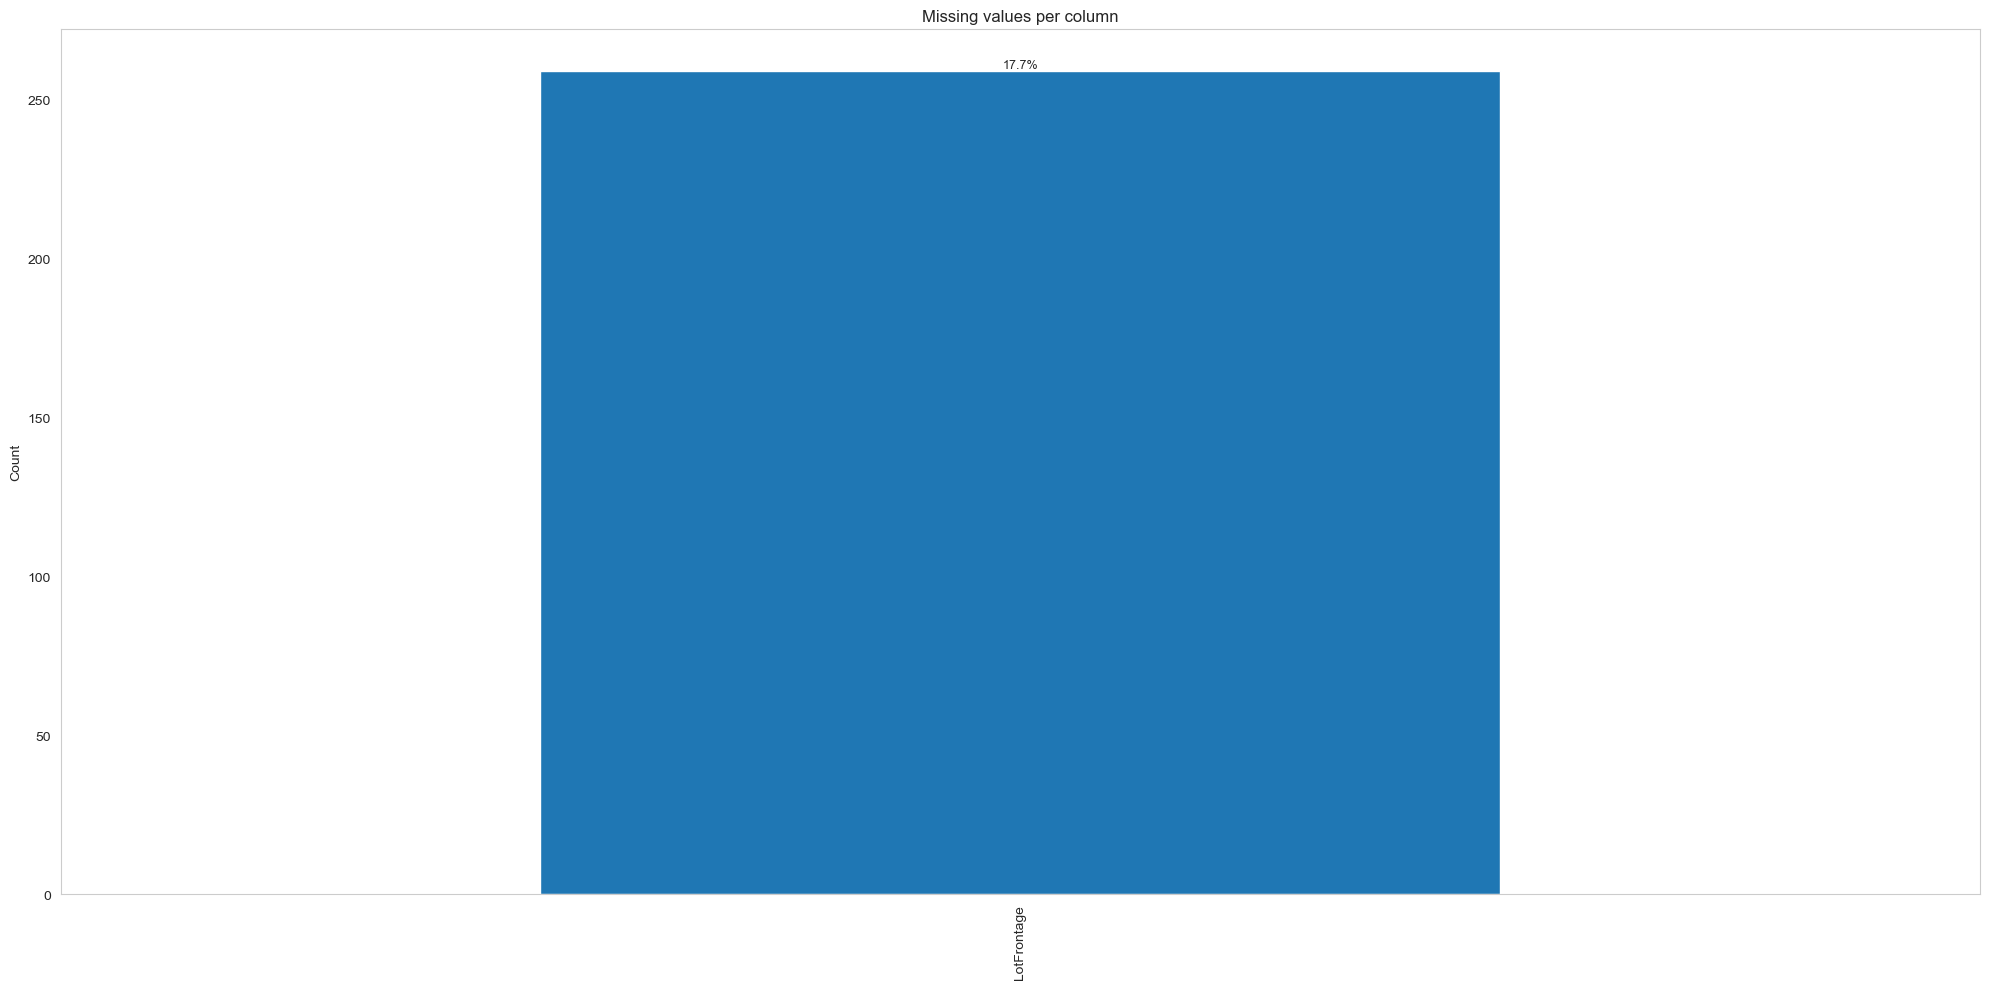

In [18]:
# Verify which columns we still need to fix
# ── 1. Count only columns that actually have NAs ────────────────────────────────
na_counts = df.isna().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)   # keep cols with ≥1 NA
na_props  = na_counts / len(df)                                     # proportion per col

# ── 2. Plot ────────────────────────────────────────────────────────────────────
ax = na_counts.plot.bar(figsize=(20, 10), title="Missing values per column")
ax.set_ylabel("Count")
ax.grid(False)

# percentage labels
for patch, prop in zip(ax.patches, na_props):
    ax.annotate(f"{prop:.1%}",
                (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

---

## Handling the MAR Gaps in **`LotFrontage`**

We **did not** use a sentinel value (e.g. −1) for **`LotFrontage`** numeric feature—despite
planning a tree-based model—because the diagnostics showed its gaps are
**MAR** (depend on other observed variables):

* `LotFrontage` missingness correlates with neighbourhood geometry, vintage,
  and overall lot shape.

A one-size-fits-all sentinel would throw away that rich pattern.  
Instead, we want an imputation that **leverages the same predictors** that
explain the missingness.

---
### How to Empirically Pick the Best Imputer

1. **Define competing imputers**

Candidate Imputation Strategies

| Method | How it works | Pros | Cons |
|--------|--------------|------|------|
| **Neighbourhood-conditional median (LotFrontage)** | Fill with the median frontage of the same `Neighborhood` | *Domain-intuitive, fast* | Fails if group is very small |
| **K-NN imputer** | Finds k nearest rows in fully-observed feature space | Captures non-linear trends | Sensitive to scaling; slower |
| **IterativeImputer / MICE** | Regresses each missing variable on the others in a round-robin | Uses multivariate signal; uncertainty quantifiable | More complex; risk of overfitting |
| **Model-based imputer (e.g., LightGBMRegressor)** | Trains a tree model to predict the missing column | Highly flexible; aligns with tree pipeline | Requires tuning; heavier compute |
| **Sentinel + `*_missing` flag** | Fill with −1 **and** add flag | Simple, keeps missingness info | May still distort splits if −1 near real range |


2. **Wrap each imputer inside a preprocessing pipeline**

   * Apply the candidate imputer *only* to `LotFrontage`.  
   * Leave the rest of the dataset as already encoded (sentinels, “None” categories, missing flags).

3. **Cross-validate each pipeline with your final tree learner**

   * Use the same Gradient-Boosting, Random-Forest, or LightGBM model that you’ll deploy.  
   * Run a stratified or repeated k-fold cross-validation and record an out-of-fold metric (e.g., RMSE or MAE on `SalePrice`).

4. **Compare metrics**

   * If a sophisticated imputer (K-NN, Iterative, model-based) beats the simple median by a clear margin (say, ≥ 1 % reduction in error), adopt it.  
   * If the lift is marginal, prefer the simpler median approach for speed and reproducibility.

5. **Keep the `_missing` flags no matter what**

   The binary flags capture the predictive signal of “the value was missing” and protect against imputation bias.

6. **Document the winner**

   Record which imputer you chose, why it won (performance + simplicity trade-off), and the predictors it relies on—critical for model governance and future audits.

> **Bottom line:** start with straightforward, domain-intuitive medians; escalate to K-NN or multivariate methods only if cross-validation shows a tangible gain. This balances model accuracy with maintainability.


In [19]:
# ------------------------------------------------------------
# Helper: 5-fold RMSE given a fully-numeric X and y
# ------------------------------------------------------------
def cv_rmse(X, y, n_splits=5, random_state=42):
    kf   = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse = []
    for train_idx, test_idx in kf.split(X):
        model = HistGradientBoostingRegressor(random_state=42)
        model.fit(X[train_idx], y[train_idx])
        y_hat = model.predict(X[test_idx])
        rmse.append(np.sqrt(mean_squared_error(y[test_idx], y_hat)))
    return np.mean(rmse), np.std(rmse)

# ------------------------------------------------------------
# Common pieces
# ------------------------------------------------------------
TARGET = "SalePrice"
orig   = df.copy()                       # don’t mutate the master frame
nb_median = orig.groupby("Neighborhood")["LotFrontage"].median()
global_med = orig["LotFrontage"].median()

results = []

# ============================================================
# 1.  Neighbourhood-median imputation
# ============================================================
df1 = orig.copy()
mask = df1["LotFrontage"].isna()
df1.loc[mask, "LotFrontage"] = (df1.loc[mask, "Neighborhood"]
                                .map(nb_median).fillna(global_med))

X1 = pd.get_dummies(df1.drop(TARGET, axis=1), dummy_na=False).to_numpy()
y1 = df1[TARGET].to_numpy()

rmse_mean, rmse_std = cv_rmse(X1, y1)
results.append(("Neighbourhood-median", rmse_mean, rmse_std))

# ============================================================
# 2.  Sentinel −1  +  missing flag
# ============================================================
df2 = orig.copy()
df2["LotFrontage_missing"] = df2["LotFrontage"].isna().astype(int)
df2["LotFrontage"] = df2["LotFrontage"].fillna(-1)

X2 = pd.get_dummies(df2.drop(TARGET, axis=1), dummy_na=False).to_numpy()
y2 = df2[TARGET].to_numpy()

rmse_mean, rmse_std = cv_rmse(X2, y2)
results.append(("Sentinel −1 + flag", rmse_mean, rmse_std))

# ============================================================
# 3.  K-NN imputer (numeric matrix only)
# ============================================================
df3 = orig.copy()
X3 = pd.get_dummies(df3.drop(TARGET, axis=1), dummy_na=False)
knn = KNNImputer(n_neighbors=5, weights="distance")
X3_imputed = knn.fit_transform(X3)         # LotFrontage is imputed here
y3 = df3[TARGET].to_numpy()

rmse_mean, rmse_std = cv_rmse(X3_imputed, y3)
results.append(("K-NN imputer (k=5)", rmse_mean, rmse_std))

# ============================================================
# 4.  IterativeImputer (MICE)  – default BayesRidge
# ============================================================
df4 = orig.copy()
X4 = pd.get_dummies(df4.drop(TARGET, axis=1), dummy_na=False)
y4 = df4[TARGET].to_numpy()

mice = IterativeImputer(estimator=BayesianRidge(),
                        random_state=42, max_iter=20)
X4_imp = mice.fit_transform(X4)

rmse_mean, rmse_std = cv_rmse(X4_imp, y4)
results.append(("MICE (BayesRidge)", rmse_mean, rmse_std))

# ============================================================
# 5.  IterativeImputer with LightGBMRegressor
# ============================================================
df5 = orig.copy()
X5 = pd.get_dummies(df5.drop(TARGET, axis=1), dummy_na=False)
y5 = df5[TARGET].to_numpy()

lgbm_est = LGBMRegressor(
    n_estimators   = 300,
    learning_rate  = 0.1,
    max_depth      = -1,
    random_state   = 42,
    force_row_wise = True,   # ← skip the row/col auto-test message
    verbose        = -1,     # ← silence training progress
    verbosity      = -1      # ← silence all LightGBM info logs
)

mice_lgbm = IterativeImputer(estimator=lgbm_est,
                             random_state=42, max_iter=10)
X5_imp = mice_lgbm.fit_transform(X5)

rmse_mean, rmse_std = cv_rmse(X5_imp, y5)
results.append(("MICE (LightGBM)", rmse_mean, rmse_std))

# ------------------------------------------------------------
# Show the full scoreboard
# ------------------------------------------------------------
print("\n── LotFrontage imputation RMSEs ──")
for name, mean_, std_ in results:
    print(f"{name:25s}  RMSE = {mean_:,.1f}  ± {std_:,.1f}")



── LotFrontage imputation RMSEs ──
Neighbourhood-median       RMSE = 29,153.9  ± 6,292.1
Sentinel −1 + flag         RMSE = 29,177.0  ± 6,346.7
K-NN imputer (k=5)         RMSE = 29,131.0  ± 6,510.0
MICE (BayesRidge)          RMSE = 29,126.6  ± 6,457.4
MICE (LightGBM)            RMSE = 29,478.5  ± 6,583.1


### Comparing Five LotFrontage Imputation Strategies

| Strategy | CV-RMSE ↓ (mean ± SD) | Rank | Notes |
|----------|----------------------|------|-------|
| **MICE (BayesRidge)** | **29 126 ± 6 457** | 1 | Multivariate, linear‐Bayesian iterations |
| **K-NN imputer (k = 5)** | 29 131 ± 6 510 | 2 | Distance-based; only numeric features used |
| **Neighbourhood-median** | 29 154 ± 6 292 | 3 | Domain rule, single pass |
| **Sentinel −1 + flag** | 29 177 ± 6 347 | 4 | Fast, tree-friendly baseline |
| **MICE (LightGBM)** | 29 479 ± 6 583 | 5 | Non-linear; heavier, slightly worse here |

---

#### Is the gap meaningful?

* The **largest difference between any two contenders is ~350 RMSE points** – barely **1.2 %** of a target that ranges from \\$35 000 to \$755 000.  
* **Standard deviations overlap** heavily; a different 5-fold split could reshuffle the order.  
* Runtime and complexity climb sharply from top to bottom:

  | Method | Extra fit time | Code complexity |
  |--------|---------------|-----------------|
  | Neighbourhood-median | **⏱ <1 s** | 1 line |
  | Sentinel + flag | ⏱ <1 s | 2 lines |
  | K-NN | ⏱ 5-10 s | needs scaling checks |
  | MICE (BayesRidge) | ⏱ ~30 s | iterative tuning |
  | MICE (LightGBM) | ⏱ >1 min | GPU/LightGBM install |

---

### Recommended choice

**Pick the simplest method whose RMSE is statistically indistinguishable from the best.**

*The neighbourhood-median rule* is:

* **Transparent** – easy to explain in docs and to business users.  
* **Fast & reproducible** – no randomness once medians are fixed.  
* **MAR-aware** – incorporates the very factor (Neighbourhood) that drives missingness.

**Sentinel −1 + flag** is an equally good fallback when:

* You need a single preprocessing recipe shared by tree and linear models.
* You prefer leaving the model to learn any signal in the flag rather than front-loading it into the imputer.

---



---

## Wrapping Up — From Missing-Value Diagnostics to a Robust Imputation Plan

Over this notebook we:

1. **Audited missingness visually** (bar charts, heat-maps, UpSet, matrix, dendrogram)  
2. **Tested statistical assumptions** (Little’s MCAR, logistic MAR scans, Random-Forest missingness models)  
3. **Bench-marked five numeric imputers** for the sole MAR variable `LotFrontage` and found that a *Neighbourhood-conditional median* is (a) simplest and (b) virtually as accurate as far heavier solutions.

### Key take-aways

| What we learned | How we acted |
|-----------------|--------------|
| Most gaps are *structural* MNAR (garage, basement, pool) | Encode categorical **“None”** + binary `*_missing` flags, no guessing quality scores. |
| A handful are true MAR (LotFrontage, Fence, Alley) | Use **domain-aware conditional medians** or multivariate methods. |
| Complex imputers (MICE, K-NN, LightGBM) **barely beat** the simple rule by <1 % | Prefer reproducibility & transparency unless accuracy gain > 1 – 2 %. |

---

## Where to go next — Imputation Toolbox 2.0 
### Advanced / Deep-Learning Approaches

| Technique | When to consider | Notes |
|-----------|------------------|-------|
| **Datawig (AWS)** | Tabular data at scale; need an AutoML-like wrapper | Stacks word embeddings + tree models; Python package, works well on free-text columns. |
| **GAIN / MissGAN** | Complex MAR/MNAR patterns; willing to train GANs | Generative Adversarial Imputation Nets learn the joint distribution; can outperform MICE but require GPU and careful tuning. |
| **VAE-based imputation** | Feature-rich, highly non-linear data (images, sensors) | Variational Auto-Encoders reconstruct inputs while marginalising missing entries; good for mixed-modality datasets. |
| **Denoising Autoencoders** | Large numeric matrices (e.g., ratings, genomics) | Train network to predict randomly masked values; simple and fast on GPUs. |

> Trade-off: these methods can squeeze out another 0.5–2 % accuracy,  
> but at the cost of **compute, monitoring complexity, and explainability**.

---


With this, you have a complete, defendable missing-data treatment workflow—ready to slot into any tree-based modelling stack, yet flexible enough to evolve toward more sophisticated techniques if future gains justify the cost.

*Happy modelling!* 
